The aim here is to compare the recovery (in terms of average summed synapse strength onto excitatory cells and firing rate distributions of excitatory cells) of a network of HVC RA-projectors and interneurons following a 50% perturbation of the RA-projectors.

Here, we compare the recovery under 3 distinct sets of plasticity rules:

1. burst timing-dependent plasticity + single-cell firing rate upper bound + population-level firing rate rule
2. burst timing-dependent plasticity + single-cell firing rate (asym about setpoint)
3. burst timing-dependent plasticity + population-level firing rate rule

In [35]:
import os
os.environ['OPENBLAS_NUM_THREADS'] = '1'

%matplotlib inline
from copy import deepcopy as copy
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import numpy as np
from scipy import stats
import scipy.io as sio
import pandas as pd
import pickle
from collections import OrderedDict
from scipy.ndimage.interpolation import shift
from functools import reduce
import time
import re
from scipy.special import comb
import time
import asyncio

from aux import Generic, bin_occurrences, safe_apply_stat, flatten
from disp import set_font_size, get_spaced_colors
from ntwk import LIFNtwkG
from utils.general import *
from utils.file_io import *

dt = 0.1e-3

In [36]:
unperturbed_purple = '#9b358b'
perturbed_green = '#32ab3a'
interneuron_blue = '#29abd1'
formerly_silent_red = '#d91e3d'

In [37]:
def save_fig(fig, path, name):
    if not os.path.exists(path):
        os.makedirs(path)
    fig.savefig(os.path.join(path, name))

In [38]:
def get_equally_spaced_colors(n, cmap='autumn'):
    cmap = plt.get_cmap(cmap)
    colors = cmap(np.linspace(0, 1, n))
    return [matplotlib.colors.rgb2hex(rgba) for rgba in colors]

In [39]:
def process_single_activation(exc_raster, n):
    # extract first spikes
    first_spk_times = np.nan * np.ones(n)
    for i in range(exc_raster.shape[1]):
        nrn_idx = int(exc_raster[1, i])
        if np.isnan(first_spk_times[nrn_idx]):
            first_spk_times[nrn_idx] = exc_raster[0, i]
    return first_spk_times

In [65]:
def load_exp_data(direc, cut=None, layer_size=20, n_exc=1600, name_frags=[], reverse=False):
    file_names = [f for f in sorted(all_files_from_dir(direc))]
    file_names = [f for f in filter_list_by_name_frags(file_names, name_frags)]
    if cut is not None:
        file_names = file_names[:cut]
        
    included_cell_mask = None
    file_name_count = range(0, len(file_names))
    if reverse:
        file_name_count = reversed(file_name_count)
    for i_f in file_name_count:
        file = file_names[i_f]
        
        if i_f == 0:
            loaded = sio.loadmat(os.path.join(direc, file))
        
        def lazy_load():
            loaded = sio.loadmat(os.path.join(direc, file))

            summed_incoming_weights = loaded['w_r_e_summed']
            summed_incoming_weights_e_i = loaded['w_r_e_i_summed']

            try:
                exc_cells_initially_active = loaded['exc_cells_initially_active'].astype(float)
                exc_cells_newly_active = loaded['exc_cells_newly_active'].astype(float)
                exc_cells_initially_active[0, :] = exc_cells_initially_active[0, :] * dt
                if exc_cells_newly_active is not None and exc_cells_newly_active.shape[0] > 0:
                    exc_cells_newly_active[0, :] = exc_cells_newly_active[0, :] * dt
                    exc_raster = np.concatenate([exc_cells_initially_active, exc_cells_newly_active], axis=1)
                else:
                    exc_raster = exc_cells_initially_active
            except KeyError as e:
                exc_cells_initially_active = loaded['exc_raster'].astype(float)
                exc_cells_initially_active[0, :] = exc_cells_initially_active[0, :]
                exc_cells_newly_active = None
                exc_raster = exc_cells_initially_active
            inh_raster = loaded['inh_raster']

            try:
                surviving_cell_indices = loaded['surviving_cell_indices'][0].astype(bool)
            except KeyError as e:
                surviving_cell_indices = np.ones(summed_incoming_weights.shape[0], dtype=bool)

            summed_incoming_weights_perturbed = summed_incoming_weights[(~surviving_cell_indices).nonzero()[0]]
            summed_incoming_weights = summed_incoming_weights[(surviving_cell_indices).nonzero()[0]]

            first_spk_times = process_single_activation(exc_raster.astype(float), n_exc)

            layers_active = []
            layer_weights = []

            for i in range(0, len(first_spk_times), layer_size):
                layer_active = np.any(~np.isnan(first_spk_times[i:i+layer_size]))
                layers_active.append(layer_active)

                layer_weight = np.sum(summed_incoming_weights[i:(i + layer_size)])
                layer_weights.append(layer_weight)

            data = {
                'index': i_f,
                'layers_active': layers_active,
                'first_spk_times': first_spk_times,
                
                'mean_incoming_summed_weights': np.mean(summed_incoming_weights),
                'median_incoming_summed_weights': np.median(summed_incoming_weights),
                'std_incoming_summed_weights': np.std(summed_incoming_weights),
                'summed_incoming_weights': summed_incoming_weights,
                'summed_incoming_weights_perturbed': summed_incoming_weights_perturbed,
                
                'mean_incoming_summed_weights_e_i': np.mean(summed_incoming_weights_e_i),
                'median_incoming_summed_weights_e_i': np.median(summed_incoming_weights_e_i),
                'std_incoming_summed_weights_e_i': np.std(summed_incoming_weights_e_i),
                'summed_incoming_weights_e_i': summed_incoming_weights_e_i,
                
                'exc_cells_initially_active': exc_cells_initially_active,
                'exc_cells_newly_active': exc_cells_newly_active,
                'inh_raster': inh_raster,
                'freqs': loaded['freqs'][0],
                'spk_bins': loaded['spk_bins'][0],
                'surviving_cell_indices': surviving_cell_indices,
            }
            return data
        yield i_f, lazy_load

In [66]:
def iter_range(r, n):
    if n == 1:
        yield (0, r[0])
    else:
        for i in range(n):
            yield (i, i * (r[1] - r[0]) / (n - 1) + r[0])
            
def real_to_str(real):
    s = f'{real}'
    first_sig_digit_idx = re.search('[1-9]', s)
    if not first_sig_digit_idx:
        return s
    
    x = s.rfind('00')
    while x >= 0 and x > first_sig_digit_idx.start():
        s = s[:x]
        x = s.rfind('00')
    return s

def determine_recovered(names, timepoints, threshold=0.8):
    recovered_dir_names = []
    all_dirs = []
    for name in names:
        if type(names) is list:
            all_dirs.append([dirs for dirs in filter_list_by_name_frags(all_in_dir('./robustness'), name)])
        else:
            all_dirs.append([dirs for dirs in filter_list_by_name_frags(all_in_dir('./robustness'), [name])])
    all_recovery_pers = []
    for i, exp_dir_names in enumerate(all_dirs):
        per_recovered_for_name = 0
        for j, exp_dir_name in enumerate(exp_dir_names):
            print(exp_dir_name)
            n_active = 0
            n_count = 0
            last_layer_actives = []
            for i, data_load in load_exp_data(os.path.join('./robustness', exp_dir_name), name_frags=[]):
                if i not in timepoints:
                    continue
                data = data_load()
                n_active += int((np.sum(data['layers_active'][-10:]) >= (0.7 * 10)) & np.any(data['first_spk_times'] > 0.2))
                n_count += 1
            if n_active == 0:
                continue
            print(n_active / n_count)
            if n_active / n_count >= threshold:
                print('X')
                recovered_dir_names.append(exp_dir_name)
                per_recovered_for_name += 1
        per_recovered_for_name /= len(exp_dir_names)
        all_recovery_pers.append(per_recovered_for_name)
        
    return recovered_dir_names, all_recovery_pers


In [96]:
run_name_1 = ['settle', 'GAMMA_0_']
run_name_2 = ['settle', 'GAMMA_0.01']
run_name_3 = ['settle', 'GAMMA_0.05']

In [103]:
recovered_exp_names, all_recovery_pers = determine_recovered([
    run_name_1,
    run_name_2,
    run_name_3,
], np.arange(260, 280))


settle__DROP_SEV_0.5_BETA_0.01_SEED_2106_GAMMA_0_ALPHA_1_0.05_ff_0.5_eir_6.0_ier_0.9_2022-02-13--16:27--40:5312
1.0
X
settle__DROP_SEV_0.5_BETA_0.01_SEED_2099_GAMMA_0_ALPHA_1_0.05_ff_0.5_eir_6.0_ier_0.9_2022-02-13--16:27--25:1887
1.0
X
settle__DROP_SEV_0.5_BETA_0.01_SEED_2131_GAMMA_0_ALPHA_1_0.05_ff_0.5_eir_6.0_ier_0.9_2022-02-13--16:37--32:8754
1.0
X
settle__DROP_SEV_0.5_BETA_0.01_SEED_2121_GAMMA_0_ALPHA_1_0.05_ff_0.5_eir_6.0_ier_0.9_2022-02-13--16:28--27:2544
1.0
X
settle__DROP_SEV_0.5_BETA_0.01_SEED_2117_GAMMA_0_ALPHA_1_0.05_ff_0.5_eir_6.0_ier_0.9_2022-02-13--16:28--23:2368
1.0
X
settle__DROP_SEV_0.5_BETA_0.01_SEED_2103_GAMMA_0_ALPHA_1_0.05_ff_0.5_eir_6.0_ier_0.9_2022-02-13--16:27--27:6747
1.0
X
settle__DROP_SEV_0.5_BETA_0.01_SEED_2137_GAMMA_0_ALPHA_1_0.05_ff_0.5_eir_6.0_ier_0.9_2022-02-14--06:45--04:0965
1.0
X
settle__DROP_SEV_0.5_BETA_0.01_SEED_2097_GAMMA_0_ALPHA_1_0.05_ff_0.5_eir_6.0_ier_0.9_2022-02-13--16:27--25:3431
1.0
X
settle__DROP_SEV_0.5_BETA_0.01_SEED_2136_GAMMA_0_ALPHA_1

1.0
X
settle__DROP_SEV_0.5_BETA_0.01_SEED_2126_GAMMA_0.01_ALPHA_1_0.05_ff_0.5_eir_6.0_ier_0.9_2022-02-13--16:37--32:9096
1.0
X
settle__DROP_SEV_0.5_BETA_0.01_SEED_2127_GAMMA_0.01_ALPHA_1_0.05_ff_0.5_eir_6.0_ier_0.9_2022-02-13--16:37--32:3559
1.0
X
settle__DROP_SEV_0.5_BETA_0.01_SEED_2097_GAMMA_0.01_ALPHA_1_0.05_ff_0.5_eir_6.0_ier_0.9_2022-02-13--16:27--25:3431
1.0
X
settle__DROP_SEV_0.5_BETA_0.01_SEED_2139_GAMMA_0.01_ALPHA_1_0.05_ff_0.5_eir_6.0_ier_0.9_2022-02-14--06:45--04:1988
settle__DROP_SEV_0.5_BETA_0.01_SEED_2120_GAMMA_0.01_ALPHA_1_0.05_ff_0.5_eir_6.0_ier_0.9_2022-02-13--16:28--27:6509
1.0
X
settle__DROP_SEV_0.5_BETA_0.01_SEED_2091_GAMMA_0.01_ALPHA_1_0.05_ff_0.5_eir_6.0_ier_0.9_2022-02-13--16:27--17:7621
1.0
X
settle__DROP_SEV_0.5_BETA_0.01_SEED_2117_GAMMA_0.01_ALPHA_1_0.05_ff_0.5_eir_6.0_ier_0.9_2022-02-13--16:28--23:2368
1.0
X
settle__DROP_SEV_0.5_BETA_0.01_SEED_2138_GAMMA_0.01_ALPHA_1_0.05_ff_0.5_eir_6.0_ier_0.9_2022-02-14--06:45--04:0714
settle__DROP_SEV_0.5_BETA_0.01_SEED_20

1.0
X
settle__DROP_SEV_0.5_BETA_0.01_SEED_2137_GAMMA_0.05_ALPHA_1_0.05_ff_0.5_eir_6.0_ier_0.9_2022-02-14--06:45--04:0965
settle__DROP_SEV_0.5_BETA_0.01_SEED_2132_GAMMA_0.05_ALPHA_1_0.05_ff_0.5_eir_6.0_ier_0.9_2022-02-13--16:37--32:9985
1.0
X
settle__DROP_SEV_0.5_BETA_0.01_SEED_2138_GAMMA_0.05_ALPHA_1_0.05_ff_0.5_eir_6.0_ier_0.9_2022-02-14--06:45--04:0714
settle__DROP_SEV_0.5_BETA_0.01_SEED_2105_GAMMA_0.05_ALPHA_1_0.05_ff_0.5_eir_6.0_ier_0.9_2022-02-13--16:27--40:9637
1.0
X
settle__DROP_SEV_0.5_BETA_0.01_SEED_2108_GAMMA_0.05_ALPHA_1_0.05_ff_0.5_eir_6.0_ier_0.9_2022-02-13--16:27--52:9700
1.0
X
settle__DROP_SEV_0.5_BETA_0.01_SEED_2100_GAMMA_0.05_ALPHA_1_0.05_ff_0.5_eir_6.0_ier_0.9_2022-02-13--16:27--27:8471
1.0
X
settle__DROP_SEV_0.5_BETA_0.01_SEED_2136_GAMMA_0.05_ALPHA_1_0.05_ff_0.5_eir_6.0_ier_0.9_2022-02-14--06:45--04:0852
settle__DROP_SEV_0.5_BETA_0.01_SEED_2122_GAMMA_0.05_ALPHA_1_0.05_ff_0.5_eir_6.0_ier_0.9_2022-02-13--16:28--27:9750
1.0
X
settle__DROP_SEV_0.5_BETA_0.01_SEED_2101_GAM

In [ ]:
all_recovery_pers

In [ ]:
def downsample_raster(raster, cell_idxs_to_show):
    j = 0
    sorted_raster = np.array([y for y in sorted(raster.T, key=lambda x: x[1])]).T
    downsampled = []
    for i in range(sorted_raster.shape[1]):
        while j < len(cell_idxs_to_show) and sorted_raster[1, i] > cell_idxs_to_show[j]:
            j += 1
        if j == len(cell_idxs_to_show):
            break
        if sorted_raster[1, i] == cell_idxs_to_show[j]:
            downsampled.append(sorted_raster[:, i])
    if len(downsampled) > 0:
        return np.stack(downsampled).T
    else:
        return np.array([])

def make_figure_1_sparse(name, cell_range=(0, 1600), per_shown=1., layer_size=20, timepoints = [0, 72, 73], sort_timepoint=300, verify_chain_timepoints=None, color='black'):
    if type(name) is list:
        all_dirs = filter_list_by_name_frags(all_in_dir('./robustness'), name)
    else:
        all_dirs = filter_list_by_name_frags(all_in_dir('./robustness'), [name])
    
    colors = get_equally_spaced_colors(20, cmap='gist_ncar')
    
    def rendition_label(n):
        if n == 0:
            n = 1
            return f'{n}' + r'$^{st}$ rendition'
        else:
            return f'{n}' + r'$^{th}$ rendition'
        
    if verify_chain_timepoints is None:
        verify_chain_timepoints = np.arange(3)
    
    count = 0
    for d_idx, exp_dir_name in enumerate(sorted(all_dirs)):
        if exp_dir_name not in recovered_exp_names:
            continue
        if count >= 10:
            continue
        count += 1
        print(exp_dir_name)
        scale = 1.1
        
        fig = plt.figure(constrained_layout=True, figsize=(5 * len(timepoints) * scale, 5 * scale))
        gs = gridspec.GridSpec(ncols=len(timepoints), nrows=3, figure=fig)
        axs = [(fig.add_subplot(gs[:1, i]), fig.add_subplot(gs[1:, i])) for i in range(len(timepoints))]
           
        timepoint_names = [rendition_label(t * 10) for t in timepoints]
        j = len(timepoints) - 1
        
        first_first_spk_in_range = None
        last_first_spk_in_range = None
        
        cell_idxs_to_show = None
        cell_idx_names = None
        sorted_order = None

        for i, load_data in load_exp_data(os.path.join('./robustness', exp_dir_name), name_frags=['dropout_0'], reverse=True):
            if i == sort_timepoint:
                data = load_data()
                first_spk_times = data['first_spk_times']
                firing_idxs = np.arange(len(first_spk_times))[~np.isnan(first_spk_times)]
                first_spk_times_nonnan = first_spk_times[~np.isnan(first_spk_times)]
                
                cell_idxs_to_show = firing_idxs[np.logical_and(firing_idxs >= cell_range[0], firing_idxs < cell_range[1])].astype(int)
                shown_first_spk_times = first_spk_times_nonnan[np.logical_and(firing_idxs >= cell_range[0], firing_idxs < cell_range[1])]
                
                to_show_mask = []
                for i_k, k in enumerate(range(0, len(firing_idxs), layer_size)):  
                    x = np.zeros(layer_size)
                    if i_k % 1 == 0:
                        x[:int(per_shown * layer_size)] = 1
                    np.random.shuffle(x)
                    x = x[:np.minimum(layer_size, len(firing_idxs) - k)]
                    to_show_mask.append(x)
                to_show_mask = np.concatenate(to_show_mask).astype(bool)
                
                cell_idxs_to_show = cell_idxs_to_show[to_show_mask]
                shown_first_spk_times = shown_first_spk_times[to_show_mask]
                
                first_first_spk_in_range = np.nanmin(shown_first_spk_times)
                last_first_spk_in_range = np.nanmax(shown_first_spk_times)
                
                
                cell_idx_to_order_map = np.zeros(np.max(cell_idxs_to_show) + 1).astype(int)
                for i in range(len(cell_idxs_to_show)):
                    cell_idx_to_order_map[cell_idxs_to_show[i]] = i
                
                sorted_order = np.nan * np.ones(len(shown_first_spk_times))
                for i, k in enumerate(np.argsort(shown_first_spk_times)):
                    sorted_order[k] = i
                sorted_order = sorted_order[cell_idx_to_order_map]
                
            if j >= 0 and i == timepoints[j]:
                print(j, timepoints[j])
                data = load_data()
                exc_cells_initially_active = data['exc_cells_initially_active']
                exc_cells_newly_active = data['exc_cells_newly_active']
                
                exc_cells_initially_active_downsampled = downsample_raster(exc_cells_initially_active, cell_idxs_to_show)
                if exc_cells_newly_active is not None and len(exc_cells_newly_active) > 0:
                    exc_cells_newly_active_downsampled = downsample_raster(exc_cells_newly_active, cell_idxs_to_show)
                
                inh_raster = data['inh_raster']
                first_spk_times = data['first_spk_times']
                
                if len(exc_cells_initially_active_downsampled) == 0:
                    continue

                if j == 0:
                    axs[j][1].scatter(exc_cells_initially_active_downsampled[0, :] * 1000, sorted_order[exc_cells_initially_active_downsampled[1, :].astype(int)], s=10, c='black', zorder=0, alpha=1, marker='|')
                else:
                    axs[j][1].scatter(exc_cells_initially_active_downsampled[0, :] * 1000, sorted_order[exc_cells_initially_active_downsampled[1, :].astype(int)], s=10, c='black', zorder=0, alpha=1, marker='|')
                    if exc_cells_newly_active is not None and len(exc_cells_newly_active) > 0 and len(exc_cells_newly_active_downsampled) > 0:
                        axs[j][1].scatter(exc_cells_newly_active_downsampled[0, :] * 1000, sorted_order[exc_cells_newly_active_downsampled[1, :].astype(int)], s=10, c=formerly_silent_red, zorder=1, alpha=1, marker='|')
                
                if len(inh_raster) > 0:
                    axs[j][0].scatter(inh_raster[0, :] * 1000, inh_raster[1, :] - 1600, s=10, c=interneuron_blue, zorder=0, alpha=1, marker='|')
                axs[j][1].set_ylim(np.min(cell_idx_names), np.max(cell_idx_names))
                axs[j][0].set_ylim(0, 25)
                axs[j][0].set_ylabel('Inhibitory\ncell Index')
                axs[j][1].set_ylabel('Excitatory\ncell Index')
                axs[j][1].set_xlabel('Time (ms)')
                axs[j][0].title.set_text(f'{timepoint_names[j]}')
            
                axs[j][0].spines['bottom'].set_visible(False)
                axs[j][1].spines['top'].set_visible(False)
                axs[j][0].tick_params(bottom=False, labelbottom=False)
                
                for row_idx in range(2):
                    # axs[j][row_idx].set_xlim((first_first_spk_in_range - 0.001) * 1000, (last_first_spk_in_range + 0.001) * 1000)
                    axs[j][row_idx].set_xlim(0.09 * 1000, (last_first_spk_in_range + 0.001) * 1000)
                    set_font_size(axs[j][row_idx], 16)
                    axs[j][row_idx].spines['right'].set_visible(False)
                    axs[j][row_idx].set_ylim(6)
                j -= 1
        
        fig.tight_layout()  
        save_fig(fig, './figures/paper/rasters', f'{exp_dir_name}.svg')
        

settle__DROP_SEV_0.5_BETA_0.01_SEED_2090_GAMMA_0_ALPHA_1_0.05_ff_0.5_eir_6.0_ier_0.9_2022-02-13--16:27--17:9218
1 280
0 149


<ipython-input-105-29ac7af1bef9>:139: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  fig.tight_layout()


settle__DROP_SEV_0.5_BETA_0.01_SEED_2091_GAMMA_0_ALPHA_1_0.05_ff_0.5_eir_6.0_ier_0.9_2022-02-13--16:27--17:7621
1 280
0 149
settle__DROP_SEV_0.5_BETA_0.01_SEED_2092_GAMMA_0_ALPHA_1_0.05_ff_0.5_eir_6.0_ier_0.9_2022-02-13--16:27--17:5090
1 280
0 149
settle__DROP_SEV_0.5_BETA_0.01_SEED_2093_GAMMA_0_ALPHA_1_0.05_ff_0.5_eir_6.0_ier_0.9_2022-02-13--16:27--17:5317
1 280
0 149
settle__DROP_SEV_0.5_BETA_0.01_SEED_2094_GAMMA_0_ALPHA_1_0.05_ff_0.5_eir_6.0_ier_0.9_2022-02-13--16:27--17:2043
1 280
0 149
settle__DROP_SEV_0.5_BETA_0.01_SEED_2095_GAMMA_0_ALPHA_1_0.05_ff_0.5_eir_6.0_ier_0.9_2022-02-13--16:27--17:5495
1 280
0 149
settle__DROP_SEV_0.5_BETA_0.01_SEED_2096_GAMMA_0_ALPHA_1_0.05_ff_0.5_eir_6.0_ier_0.9_2022-02-13--16:27--17:5280
1 280
0 149
settle__DROP_SEV_0.5_BETA_0.01_SEED_2097_GAMMA_0_ALPHA_1_0.05_ff_0.5_eir_6.0_ier_0.9_2022-02-13--16:27--25:3431
1 280
0 149
settle__DROP_SEV_0.5_BETA_0.01_SEED_2098_GAMMA_0_ALPHA_1_0.05_ff_0.5_eir_6.0_ier_0.9_2022-02-13--16:27--25:4518
1 280
0 149
settle__

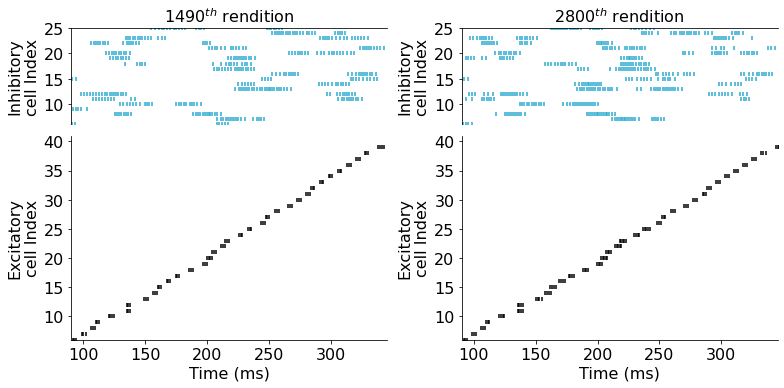

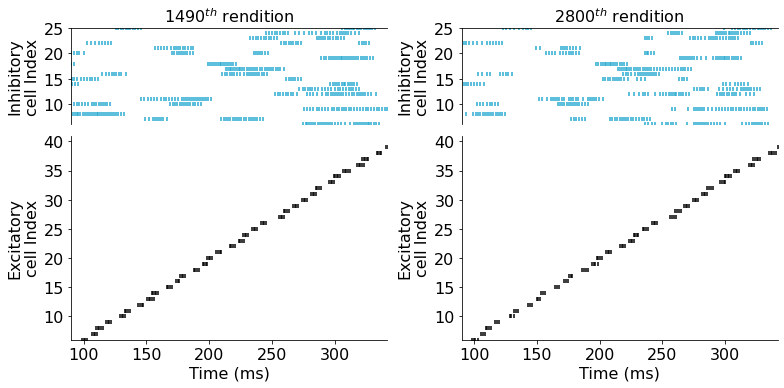

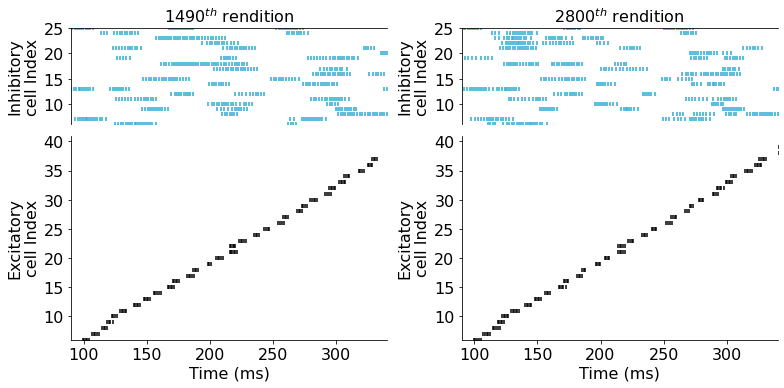

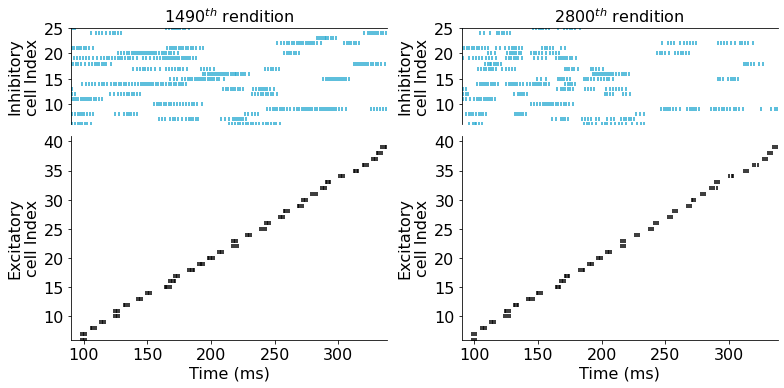

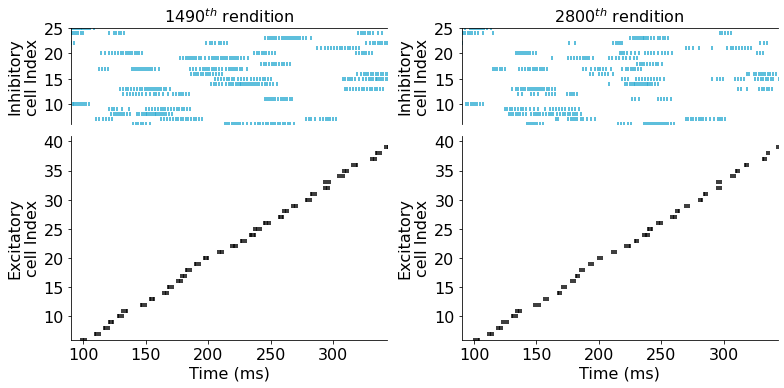

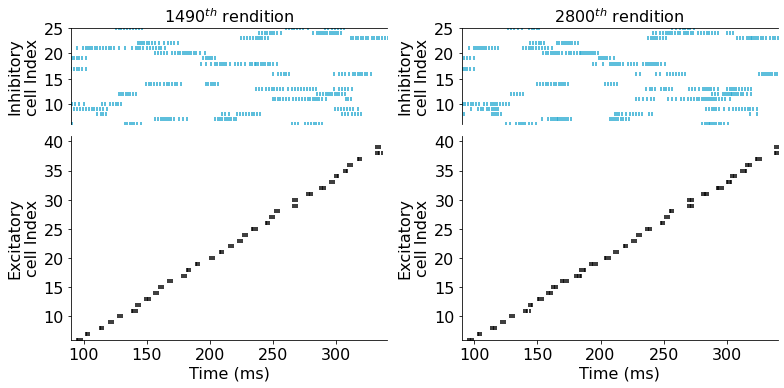

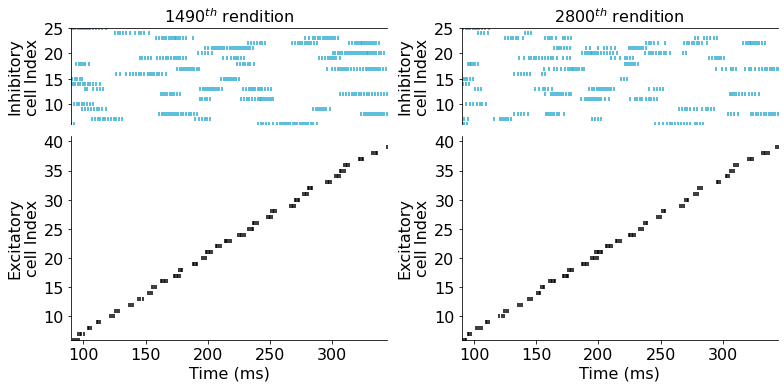

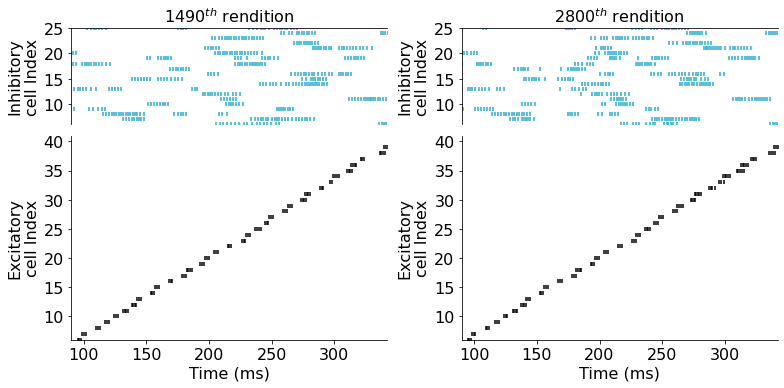

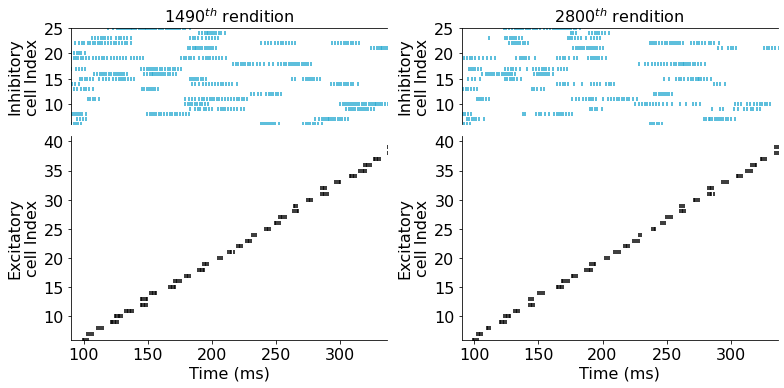

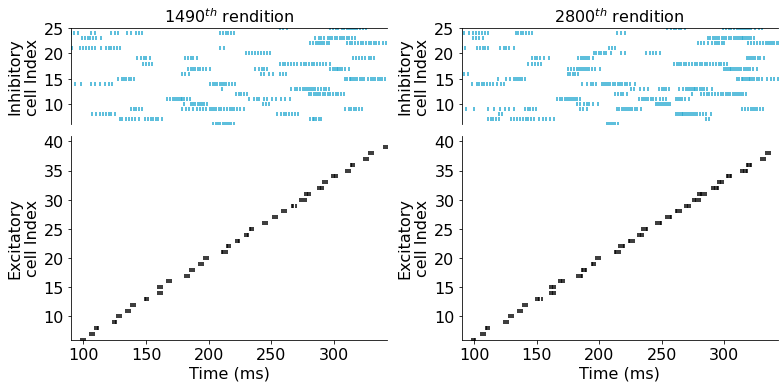

In [108]:
make_figure_1_sparse(run_name_1, cell_range=(0, 1600), timepoints=[149, 280], sort_timepoint=281, per_shown=0.05, color='#c41f3b')


settle__DROP_SEV_0.5_BETA_0.01_SEED_2090_GAMMA_0.01_ALPHA_1_0.05_ff_0.5_eir_6.0_ier_0.9_2022-02-13--16:27--17:9218
1 280
0 149


<ipython-input-105-29ac7af1bef9>:139: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  fig.tight_layout()


settle__DROP_SEV_0.5_BETA_0.01_SEED_2091_GAMMA_0.01_ALPHA_1_0.05_ff_0.5_eir_6.0_ier_0.9_2022-02-13--16:27--17:7621
1 280
0 149
settle__DROP_SEV_0.5_BETA_0.01_SEED_2092_GAMMA_0.01_ALPHA_1_0.05_ff_0.5_eir_6.0_ier_0.9_2022-02-13--16:27--17:5090
1 280
0 149
settle__DROP_SEV_0.5_BETA_0.01_SEED_2093_GAMMA_0.01_ALPHA_1_0.05_ff_0.5_eir_6.0_ier_0.9_2022-02-13--16:27--17:5317
1 280
0 149
settle__DROP_SEV_0.5_BETA_0.01_SEED_2094_GAMMA_0.01_ALPHA_1_0.05_ff_0.5_eir_6.0_ier_0.9_2022-02-13--16:27--17:2043
1 280
0 149
settle__DROP_SEV_0.5_BETA_0.01_SEED_2095_GAMMA_0.01_ALPHA_1_0.05_ff_0.5_eir_6.0_ier_0.9_2022-02-13--16:27--17:5495
1 280
0 149
settle__DROP_SEV_0.5_BETA_0.01_SEED_2096_GAMMA_0.01_ALPHA_1_0.05_ff_0.5_eir_6.0_ier_0.9_2022-02-13--16:27--17:5280
1 280
0 149
settle__DROP_SEV_0.5_BETA_0.01_SEED_2097_GAMMA_0.01_ALPHA_1_0.05_ff_0.5_eir_6.0_ier_0.9_2022-02-13--16:27--25:3431
1 280
0 149
settle__DROP_SEV_0.5_BETA_0.01_SEED_2098_GAMMA_0.01_ALPHA_1_0.05_ff_0.5_eir_6.0_ier_0.9_2022-02-13--16:27--25:4

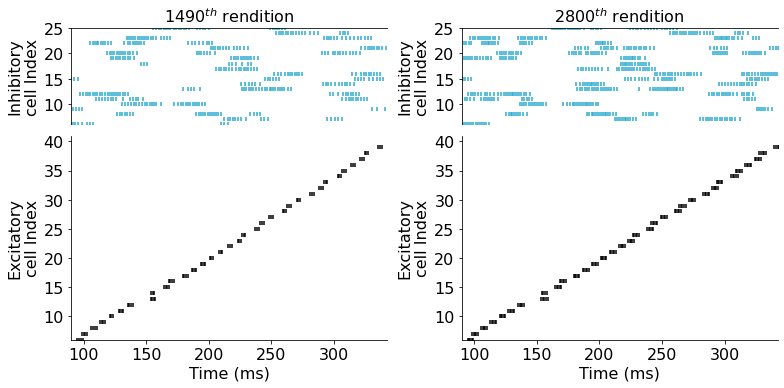

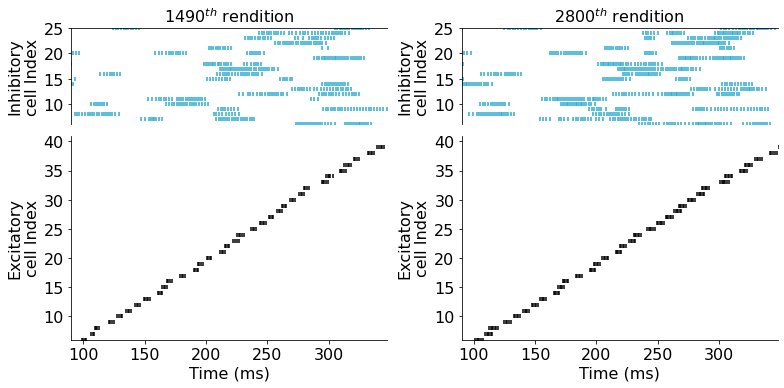

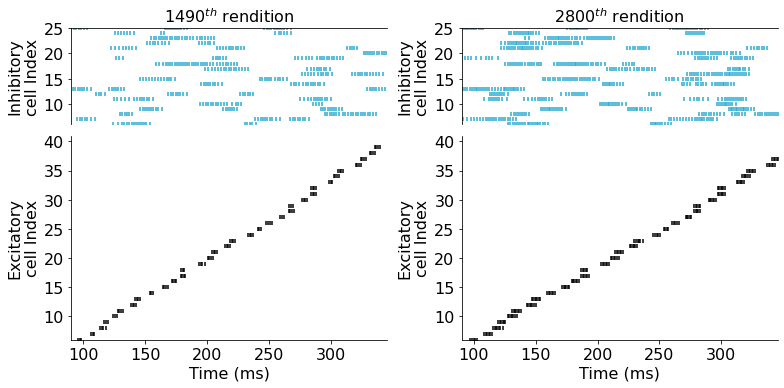

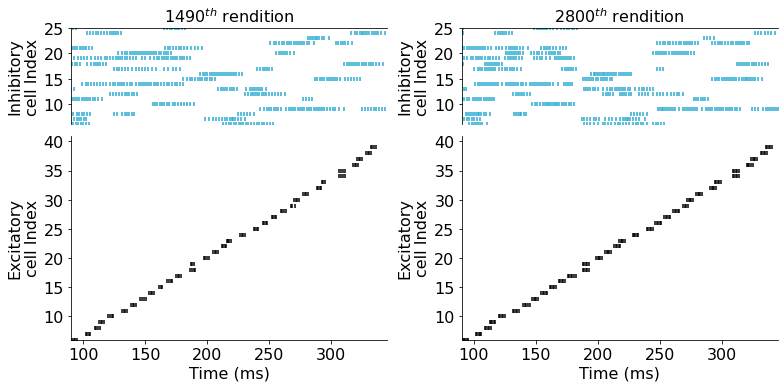

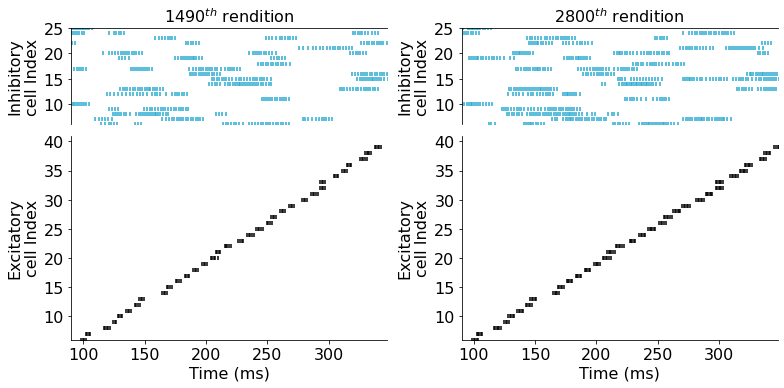

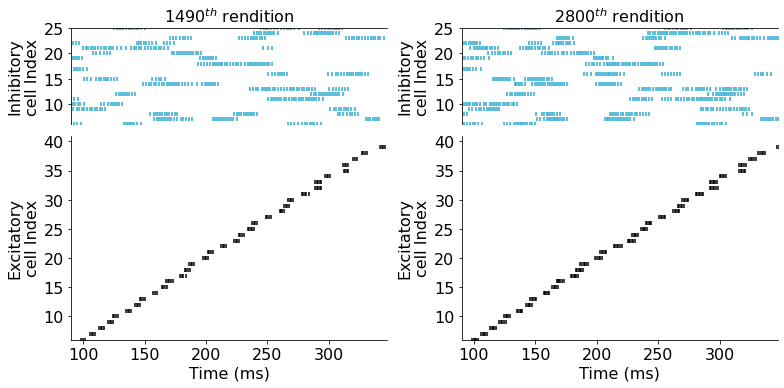

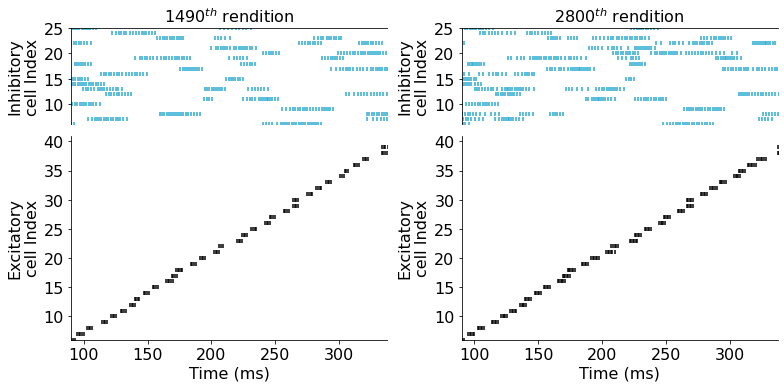

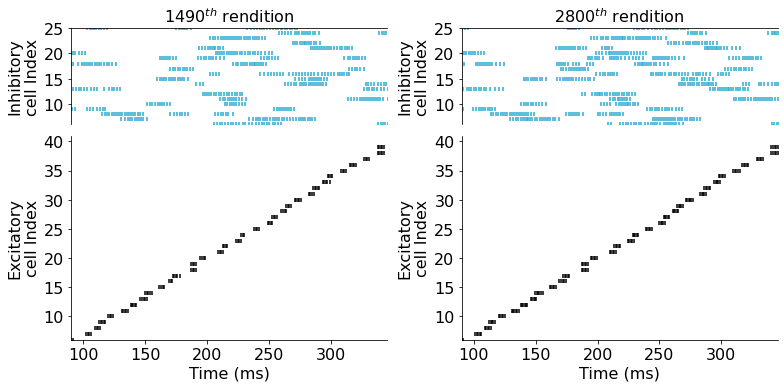

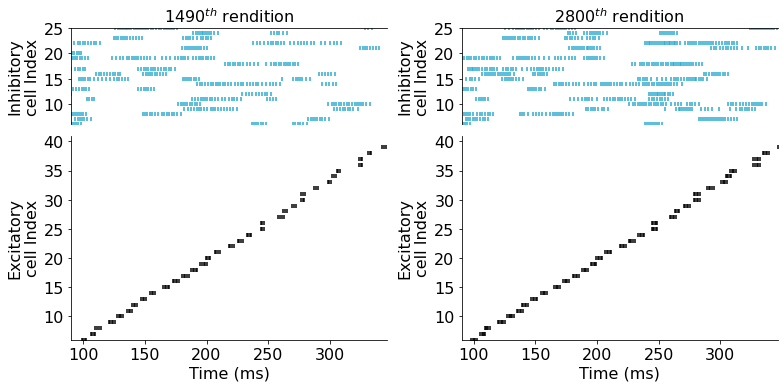

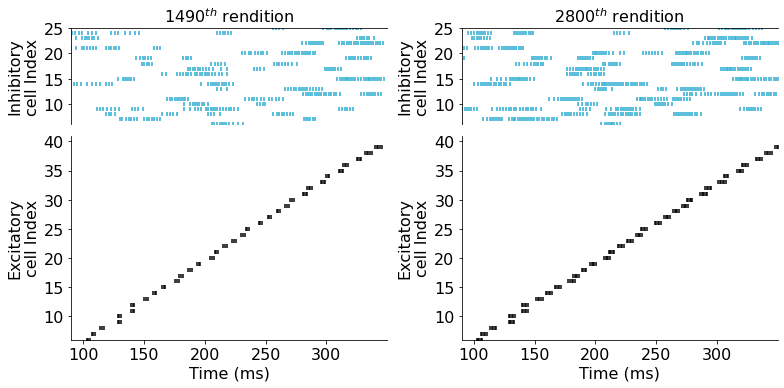

In [118]:
make_figure_1_sparse(run_name_2, cell_range=(0, 1600), timepoints=[149, 280], sort_timepoint=281, per_shown=0.05, color='#c41f3b')


In [ ]:
def make_figure_2_plot(names, labels, condition_colors, file_name_ext='', ylim1=None, ylim2=None, ylabel1=None, ylabel2=None, timepoints=[], offsets=[], vertical_spacing=1., axs=None, fig=None, tick_right=True, legend=True):
    
    scale = 2.5
    
    if fig is None:
        fig, axs = plt.subplots(1, 2, sharex=True, sharey=False, figsize=(6 * scale, 2.5 * scale))
    
    all_dirs = []
    for name in names:
        if type(name) is not list:
            name = [name]
        print(name)
        all_dirs.append([dirs for dirs in filter_list_by_name_frags(all_in_dir('./robustness'), name)])
        
    timepoints = np.array(timepoints)
        
    for idx, exp_dir_names in enumerate(all_dirs):
        all_weights_for_dir_name = []
        all_weights_e_i_for_dir_name = []
        
        for j, exp_dir_name in enumerate(exp_dir_names):
            if exp_dir_name not in recovered_exp_names:
                continue
            if j > 5:
                continue
            print(exp_dir_name)
            
            all_mean_incoming_summed_weights = []
            all_std_incoming_summed_weights = []
            all_mean_incoming_summed_weights_e_i = []
            all_std_incoming_summed_weights_e_i = []
            baseline_mean = None
            baseline_std = None
            baseline_mean_e_i = None
            baseline_std_e_i = None

            for i, data_load in load_exp_data(os.path.join('./robustness', exp_dir_name), name_frags=[]):
                if i not in timepoints:
                    continue
                data = data_load()
                
                all_mean_incoming_summed_weights.append(data['mean_incoming_summed_weights'])
                all_std_incoming_summed_weights.append(data['std_incoming_summed_weights'])
                all_mean_incoming_summed_weights_e_i.append(data['mean_incoming_summed_weights_e_i'])
                all_std_incoming_summed_weights_e_i.append(data['std_incoming_summed_weights_e_i'])

                if i == offsets[idx]:
                    baseline_mean = data['mean_incoming_summed_weights']
                    baseline_std = data['std_incoming_summed_weights']
                    baseline_mean_e_i = data['mean_incoming_summed_weights_e_i']
                    baseline_std_e_i = data['std_incoming_summed_weights_e_i']
                       
            all_mean_incoming_summed_weights = np.array(all_mean_incoming_summed_weights) / baseline_mean
            all_std_incoming_summed_weights = np.array(all_std_incoming_summed_weights) / baseline_mean
            all_mean_incoming_summed_weights_e_i = np.array(all_mean_incoming_summed_weights_e_i) / baseline_mean_e_i
            all_std_incoming_summed_weights_e_i = np.array(all_std_incoming_summed_weights_e_i) / baseline_mean_e_i
                
            all_weights_for_dir_name.append(all_mean_incoming_summed_weights)
            all_weights_e_i_for_dir_name.append(all_mean_incoming_summed_weights_e_i)
            
#             axs[0].plot(timepoints[:len(all_mean_incoming_summed_weights)] * 10, all_mean_incoming_summed_weights, color='black', lw=0.5, zorder=-1)
#             axs[1].plot(timepoints[:len(all_mean_incoming_summed_weights_e_i)] * 10, all_mean_incoming_summed_weights_e_i, color='black', lw=0.5, zorder=-1)

        
        if len(all_weights_for_dir_name) == 0:
            continue
        
        e_e_means = safe_apply_stat(all_weights_for_dir_name, np.mean)
        e_e_sems = safe_apply_stat(all_weights_for_dir_name, lambda x: np.std(x) / np.sqrt(len(x)))
        e_i_means = safe_apply_stat(all_weights_e_i_for_dir_name, np.mean)
        e_i_sems = safe_apply_stat(all_weights_e_i_for_dir_name, lambda x: np.std(x) / np.sqrt(len(x)))

        y_disp = vertical_spacing * idx

        axs[0].fill_between(
            timepoints * 10,
            e_e_means - e_e_sems + y_disp,
            e_e_means + e_e_sems + y_disp,
            color=condition_colors[idx][0], alpha=0.2, zorder=0)
        axs[0].plot(timepoints * 10, e_e_means + y_disp, lw=1.5, color=condition_colors[idx][0], label=labels[idx], zorder=0)
        axs[1].fill_between(
            timepoints * 10,
            e_i_means - e_i_sems + y_disp,
            e_i_means + e_i_sems + y_disp,
            color=condition_colors[idx][1], alpha=0.2, zorder=-1)
        axs[1].plot(timepoints * 10, e_i_means + y_disp, lw=1.5, color=condition_colors[idx][1], label=labels[idx], zorder=-1)

        if ylabel1 is None:    
            axs[0].set_ylabel(r'Mean E$\rightarrow$E summed' + '\nsynapse strength')
        else:
            axs[0].set_ylabel(ylabel1)
            
        if ylabel2 is None:  
            axs[1].set_ylabel(r'Mean E$\rightarrow$I summed' + '\nsynapse strength')
        else:
            axs[1].set_ylabel(ylabel2)
        if ylim1 is not None:
                axs[0].set_ylim(ylim1[0], ylim1[1])
        if ylim2 is not None:
                axs[1].set_ylim(ylim2[0], ylim2[1])
                
        y_ticks = []
        y_tick_labels = []
        for i in range(len(names)):
            y_ticks.append(vertical_spacing * i + 0.5)
            y_ticks.append(vertical_spacing * i + 1)
            y_ticks.append(vertical_spacing * i + 1.5)
            y_tick_labels.append(0.5)
            y_tick_labels.append(1)
            y_tick_labels.append(1.5)
                
        for i in range(2):
            axs[i].set_xlim(10 * timepoints[0], 10 * timepoints[-1])
            axs[i].set_xlabel('Rendition number')
            if tick_right:
                axs[i].tick_params(right=True, labelright=True)
        
#             axs[i].set_yticks(y_ticks)
#             axs[i].set_yticklabels(y_tick_labels)
    if legend:
        axs[0].legend(loc='lower right')
    fig.tight_layout()
    save_fig(fig, './figures/paper/fig_2', f'mean_plot_{file_name_ext}.png')

In [98]:
def extract_weight_dist_stats(names, recovered_exp_names, timepoints):
    all_dirs = []
    for name in names:
        if type(names) is list:
            all_dirs.append([dirs for dirs in filter_list_by_name_frags(all_in_dir('./robustness'), name)])
        else:
            all_dirs.append([dirs for dirs in filter_list_by_name_frags(all_in_dir('./robustness'), [name])])
    
    all_weight_dist_info = []
    all_summed_weights = []
    
    for i, exp_dir_names in enumerate(all_dirs):
        
        summed_weights_for_group = [[] for t in timepoints]
        summed_weights_for_group_perturbed = [[] for t in timepoints]
        weight_freqs_for_group = [[] for t in timepoints]
        weight_bins = [[] for t in timepoints]
        
        for j, exp_dir_name in enumerate(exp_dir_names):
            if exp_dir_name not in recovered_exp_names:
                continue
            print(exp_dir_name)
            
            t_ctr = 0
            for k, data_load in load_exp_data(os.path.join('./robustness', exp_dir_name), name_frags=[]):
                if k not in timepoints:
                    continue
                data = data_load()
                
                summed_incoming_weights = data['summed_incoming_weights']
                summed_weights_for_group[t_ctr].append(summed_incoming_weights)
                summed_incoming_weights_perturbed = data['summed_incoming_weights_perturbed']
                summed_weights_for_group_perturbed[t_ctr].append(summed_incoming_weights_perturbed)
                
                bins, freqs = bin_occurrences(summed_incoming_weights, max_val=0.0035, bin_size=0.00001)
                weight_bins[t_ctr] = bins
                weight_freqs_for_group[t_ctr].append(freqs)
                
                t_ctr += 1
        
        mean_weight_dists = []
        std_weight_dists = []
        summed_weight_bins = []
        
        mean_summed_incoming_weights = []
        std_summed_incoming_weights = []
        all_summed_incoming_weights = []
        
        all_summed_incoming_weights_perturbed = []
        
        for i_t, t in enumerate(timepoints):
            mean_weight_dists.append(np.nanmean(weight_freqs_for_group[i_t], axis=0))
            std_weight_dists.append(np.nanstd(weight_freqs_for_group[i_t], axis=0))
            summed_weight_bins.append(weight_bins[i_t])
            
            all_summed_incoming_weights_perturbed.append(np.array(summed_weights_for_group_perturbed[i_t]).flatten())
            all_summed_incoming_weights.append(np.array(summed_weights_for_group[i_t]).flatten())
            mean_summed_incoming_weights.append(np.nanmean(summed_weights_for_group[i_t], axis=0).flatten())
            std_summed_incoming_weights.append(np.nanstd(summed_weights_for_group[i_t], axis=0).flatten())
                
        all_weight_dist_info.append({
            'mean_weight_dists': mean_weight_dists,
            'std_weight_dists': std_weight_dists,
            'summed_weight_bins': summed_weight_bins[0],
            'mean_summed_incoming_weights': mean_summed_incoming_weights,
            'std_summed_incoming_weights': std_summed_incoming_weights,
            'all_summed_incoming_weights': all_summed_incoming_weights,
            'all_summed_incoming_weights_perturbed': all_summed_incoming_weights_perturbed,
            'name': names[i],
        })
    return all_weight_dist_info

In [110]:
all_weight_dist_info = extract_weight_dist_stats([
    run_name_1,
    run_name_2,
    run_name_3,
], recovered_exp_names, [125, 180, 260])

settle__DROP_SEV_0.5_BETA_0.01_SEED_2106_GAMMA_0_ALPHA_1_0.05_ff_0.5_eir_6.0_ier_0.9_2022-02-13--16:27--40:5312
settle__DROP_SEV_0.5_BETA_0.01_SEED_2099_GAMMA_0_ALPHA_1_0.05_ff_0.5_eir_6.0_ier_0.9_2022-02-13--16:27--25:1887
settle__DROP_SEV_0.5_BETA_0.01_SEED_2131_GAMMA_0_ALPHA_1_0.05_ff_0.5_eir_6.0_ier_0.9_2022-02-13--16:37--32:8754
settle__DROP_SEV_0.5_BETA_0.01_SEED_2121_GAMMA_0_ALPHA_1_0.05_ff_0.5_eir_6.0_ier_0.9_2022-02-13--16:28--27:2544
settle__DROP_SEV_0.5_BETA_0.01_SEED_2117_GAMMA_0_ALPHA_1_0.05_ff_0.5_eir_6.0_ier_0.9_2022-02-13--16:28--23:2368
settle__DROP_SEV_0.5_BETA_0.01_SEED_2103_GAMMA_0_ALPHA_1_0.05_ff_0.5_eir_6.0_ier_0.9_2022-02-13--16:27--27:6747
settle__DROP_SEV_0.5_BETA_0.01_SEED_2137_GAMMA_0_ALPHA_1_0.05_ff_0.5_eir_6.0_ier_0.9_2022-02-14--06:45--04:0965
settle__DROP_SEV_0.5_BETA_0.01_SEED_2097_GAMMA_0_ALPHA_1_0.05_ff_0.5_eir_6.0_ier_0.9_2022-02-13--16:27--25:3431
settle__DROP_SEV_0.5_BETA_0.01_SEED_2136_GAMMA_0_ALPHA_1_0.05_ff_0.5_eir_6.0_ier_0.9_2022-02-13--16:37--

settle__DROP_SEV_0.5_BETA_0.01_SEED_2117_GAMMA_0.01_ALPHA_1_0.05_ff_0.5_eir_6.0_ier_0.9_2022-02-13--16:28--23:2368
settle__DROP_SEV_0.5_BETA_0.01_SEED_2098_GAMMA_0.01_ALPHA_1_0.05_ff_0.5_eir_6.0_ier_0.9_2022-02-13--16:27--25:4518
settle__DROP_SEV_0.5_BETA_0.01_SEED_2111_GAMMA_0.01_ALPHA_1_0.05_ff_0.5_eir_6.0_ier_0.9_2022-02-13--16:27--57:2043
settle__DROP_SEV_0.5_BETA_0.01_SEED_2112_GAMMA_0.01_ALPHA_1_0.05_ff_0.5_eir_6.0_ier_0.9_2022-02-13--16:27--57:0877
settle__DROP_SEV_0.5_BETA_0.01_SEED_2104_GAMMA_0.01_ALPHA_1_0.05_ff_0.5_eir_6.0_ier_0.9_2022-02-13--16:27--40:4536
settle__DROP_SEV_0.5_BETA_0.01_SEED_2113_GAMMA_0.01_ALPHA_1_0.05_ff_0.5_eir_6.0_ier_0.9_2022-02-13--16:28--10:4513
settle__DROP_SEV_0.5_BETA_0.01_SEED_2125_GAMMA_0.01_ALPHA_1_0.05_ff_0.5_eir_6.0_ier_0.9_2022-02-13--16:37--32:2267
settle__DROP_SEV_0.5_BETA_0.01_SEED_2124_GAMMA_0.01_ALPHA_1_0.05_ff_0.5_eir_6.0_ier_0.9_2022-02-13--16:37--32:9242
settle__DROP_SEV_0.5_BETA_0.01_SEED_2135_GAMMA_0.01_ALPHA_1_0.05_ff_0.5_eir_6.0_

In [63]:
# pickle.dump(all_weight_dist_info, open('parsed_data_3.p', 'wb'))


In [22]:
# aggregate_weight_dist_data = pickle.load(open('./parsed_data_3.p', 'rb'))
# print(aggregate_weight_dist_data)

In [92]:
# scale = 1.3
# for k, dist_data_for_name in enumerate(all_weight_dist_info):
#     fig, axs = plt.subplots(1, 1, sharex=False, sharey=False, figsize=(6 * scale, 4 * scale))

#     if len(dist_data_for_name) > 0:
# #         widths = np.array([np.max(d) for d in dist_data_for_name['mean_weight_dists']])

#         positions = np.array([0, 1, 3])
#         parts = axs.violinplot(dist_data_for_name['all_summed_incoming_weights'], positions=positions+1, showmeans=False, showextrema=False)
#         for pc in parts['bodies']:
#             pc.set_facecolor(unperturbed_blue)
# #             pc.set_edgecolor('black')
#             pc.set_alpha(0.15)
    
#         num_to_sample = 200
#         for i, dist_data in enumerate(dist_data_for_name['all_summed_incoming_weights']):
#             indices_to_show = np.arange(len(dist_data))
#             np.random.shuffle(indices_to_show)
#             indices_to_show = indices_to_show[:num_to_sample]
#             axs.scatter(positions[i] + 1 + np.random.normal(size=num_to_sample, scale=0.05), dist_data[indices_to_show],
#                         s=10, color=unperturbed_blue, marker='o', edgecolors='#27a1c4', linewidths=0.3)
        
#         positions = np.array([2, 4])
#         parts = axs.violinplot(dist_data_for_name['all_summed_incoming_weights_perturbed'][1:], positions=positions+1, showmeans=False, showextrema=False)
#         for pc in parts['bodies']:
#             pc.set_facecolor(perturbed_green)
# #             pc.set_edgecolor('black')
#             pc.set_alpha(0.15)
    
#         num_to_sample = 200
#         for i, dist_data in enumerate(dist_data_for_name['all_summed_incoming_weights_perturbed'][1:]):
#             indices_to_show = np.arange(len(dist_data))
#             np.random.shuffle(indices_to_show)
#             indices_to_show = indices_to_show[:num_to_sample]
#             axs.scatter(positions[i] + 1 + np.random.normal(size=num_to_sample, scale=0.05), dist_data[indices_to_show],
#                         s=10, color=perturbed_green, marker='o', edgecolors=perturbed_green, linewidths=0.3)
            
            
#         axs.set_xticks(np.arange(5) + 1)
#         axs.set_xticklabels([
#             r'$1^{st}$' + '\nrendition',
#             r'$500^{th}$' + '\nrendition\n(unperturbed)',
#             r'$500^{th}$' + '\nrendition\n(perturbed)',
#             r'$2000^{th}$'  + '\nrendition\n(recovered)',
#             r'$2000^{th}$'  + '\nrendition\n(unrecovered)'
#         ])
#         axs.set_ylabel('Excitatory summed synaptic strength')
#         axs.spines['top'].set_visible(False)
#         axs.spines['right'].set_visible(False)
# #         axs.set_ylim(0, 0.0035)
#         set_font_size(axs, 14)
        
#         axs_ins = inset_axes(axs, width='40%', height='40%',
#                              bbox_transform=axs.transAxes,
#                              bbox_to_anchor=(.35, -0.03, 1, 1), loc='upper left')
        
#         axs_ins.spines['top'].set_visible(False)
#         axs_ins.spines['right'].set_visible(False)
        
#         axs_ins.tick_params(right=False, labelright=False)
        
#         timepoints = np.arange(0, 200, 1)

#         make_figure_2_plot([
#             pop_cont_drop_point_5_name_frags,
#         ], labels=[
#             '',
#         ], condition_colors=[(unperturbed_blue, interneuron_red)], timepoints=timepoints, offsets=np.zeros(3), vertical_spacing=0.,
#         file_name_ext='all_3_silent', axs=[axs_ins, axs_ins], fig=fig, tick_right=False, legend=False, ylabel2='Mean normed\nsummed synapse\nstrength')
#         set_font_size(axs, 12)
#         set_font_size(axs_ins, 12)
        
#         axs_ins.tick_params(right=False, labelright=False)
    
#         save_fig(fig, './figures/paper/weight_trajectories', f'{k}.svg')
        
# #         axs[k, 0].set_ylim(0, 0.0015)
# #         bins = dist_data_for_name['summed_weight_bins']
# #         for i_t, means in enumerate(dist_data_for_name['mean_weight_dists']):
# #             stds = dist_data_for_name['std_weight_dists'][i_t]
            
# #             axs[k, 1].fill_between(bins, means - stds, means + stds, color=colors[i_t], alpha=0.2)
# #             axs[k, 1].plot(bins, means, color=colors[i_t])

        
        
# # fig.tight_layout()

In [93]:
# scale = 1.3
# fig, axs = plt.subplots(1, 1, sharex=False, sharey=False, figsize=(6 * scale, 4 * scale))

# colors = get_equally_spaced_colors(3, cmap='winter')

# for k, dist_data_for_name in enumerate(all_weight_dist_info):
#     if len(dist_data_for_name) > 0:
#         mean_initial_summed_incoming_weight = np.mean(dist_data_for_name['all_summed_incoming_weights'][0])

# #         widths = np.array([np.max(d) for d in dist_data_for_name['mean_weight_dists']])
#         positions = np.array([0])
#         parts = axs.violinplot(dist_data_for_name['all_summed_incoming_weights'][0] / mean_initial_summed_incoming_weight, positions=positions+1, showmeans=False, showextrema=False)
#         for pc in parts['bodies']:
#             pc.set_facecolor('black')
# #             pc.set_edgecolor('black')
#             pc.set_alpha(0.15)
    
#         num_to_sample = 200
#         for i, dist_data in enumerate([dist_data_for_name['all_summed_incoming_weights'][0]]):
#             indices_to_show = np.arange(len(dist_data))
#             np.random.shuffle(indices_to_show)
#             indices_to_show = indices_to_show[:num_to_sample]
#             axs.scatter(positions[i] + 1 + np.random.normal(size=num_to_sample, scale=0.05), np.array(dist_data[indices_to_show][0]) / mean_initial_summed_incoming_weight,
#                         s=10, color='black', marker='o', edgecolors='black', linewidths=0.3)

#         positions = np.array([1, 2])
#         parts = axs.violinplot(dist_data_for_name['all_summed_incoming_weights'] / mean_initial_summed_incoming_weight, positions=positions+1, showmeans=False, showextrema=False)
#         for pc in parts['bodies']:
#             pc.set_facecolor(unperturbed_blue)
# #             pc.set_edgecolor('black')
#             pc.set_alpha(0.15)
    
#         num_to_sample = 200
#         for i, dist_data in enumerate(dist_data_for_name['all_summed_incoming_weights']):
#             indices_to_show = np.arange(len(dist_data))
#             np.random.shuffle(indices_to_show)
#             indices_to_show = indices_to_show[:num_to_sample]
#             axs.scatter(positions[i] + 1 + np.random.normal(size=num_to_sample, scale=0.05), dist_data[indices_to_show] / mean_initial_summed_incoming_weight,
#                         s=10, color=unperturbed_blue, marker='o', edgecolors='#27a1c4', linewidths=0.3)
        
#         axs.set_xticks(np.arange(3) + 1)
#         axs.set_xticklabels([
#             r'$1^{st}$' + '\nrendition',
#             r'$500^{th}$' + '\nrendition',
#             r'$2000^{th}$'  + '\nrendition',
#         ])
#         axs.set_ylabel('Excitatory summed synaptic strength')
#         axs.spines['top'].set_visible(False)
#         axs.spines['right'].set_visible(False)
# #         axs.set_ylim(0, 0.0035)
#         set_font_size(axs, 14)
        
#         axs_ins = inset_axes(axs, width='40%', height='40%',
#                              bbox_transform=axs.transAxes,
#                              bbox_to_anchor=(.35, -0.03, 1, 1), loc='upper left')
        
#         axs_ins.spines['top'].set_visible(False)
#         axs_ins.spines['right'].set_visible(False)
        
#         axs_ins.tick_params(right=False, labelright=False)
        
#         timepoints = np.arange(0, 200, 1)

#         make_figure_2_plot([
#             pop_cont_drop_point_5_name_frags,
#         ], labels=[
#             '',
#         ], condition_colors=[(unperturbed_blue, interneuron_red)], timepoints=timepoints, offsets=np.zeros(3), vertical_spacing=0.,
#         file_name_ext='all_3_silent', axs=[axs_ins, axs_ins], fig=fig, tick_right=False, legend=False, ylabel2='Mean normed\nsummed synapse\nstrength')
#         set_font_size(axs, 12)
#         set_font_size(axs_ins, 12)
        
#         axs_ins.tick_params(right=False, labelright=False)
    
#         save_fig(fig, './figures/paper/weight_trajectories', f'{k}.svg')
        
# #         axs[k, 0].set_ylim(0, 0.0015)
# #         bins = dist_data_for_name['summed_weight_bins']
# #         for i_t, means in enumerate(dist_data_for_name['mean_weight_dists']):
# #             stds = dist_data_for_name['std_weight_dists'][i_t]
            
# #             axs[k, 1].fill_between(bins, means - stds, means + stds, color=colors[i_t], alpha=0.2)
# #             axs[k, 1].plot(bins, means, color=colors[i_t])

        
        
# # fig.tight_layout()

['settle', 'GAMMA_0_']
settle__DROP_SEV_0.5_BETA_0.01_SEED_2106_GAMMA_0_ALPHA_1_0.05_ff_0.5_eir_6.0_ier_0.9_2022-02-13--16:27--40:5312
settle__DROP_SEV_0.5_BETA_0.01_SEED_2099_GAMMA_0_ALPHA_1_0.05_ff_0.5_eir_6.0_ier_0.9_2022-02-13--16:27--25:1887
settle__DROP_SEV_0.5_BETA_0.01_SEED_2131_GAMMA_0_ALPHA_1_0.05_ff_0.5_eir_6.0_ier_0.9_2022-02-13--16:37--32:8754
settle__DROP_SEV_0.5_BETA_0.01_SEED_2121_GAMMA_0_ALPHA_1_0.05_ff_0.5_eir_6.0_ier_0.9_2022-02-13--16:28--27:2544
settle__DROP_SEV_0.5_BETA_0.01_SEED_2117_GAMMA_0_ALPHA_1_0.05_ff_0.5_eir_6.0_ier_0.9_2022-02-13--16:28--23:2368
settle__DROP_SEV_0.5_BETA_0.01_SEED_2103_GAMMA_0_ALPHA_1_0.05_ff_0.5_eir_6.0_ier_0.9_2022-02-13--16:27--27:6747
['settle', 'GAMMA_0.01']
settle__DROP_SEV_0.5_BETA_0.01_SEED_2105_GAMMA_0.01_ALPHA_1_0.05_ff_0.5_eir_6.0_ier_0.9_2022-02-13--16:27--40:9637
settle__DROP_SEV_0.5_BETA_0.01_SEED_2092_GAMMA_0.01_ALPHA_1_0.05_ff_0.5_eir_6.0_ier_0.9_2022-02-13--16:27--17:5090
settle__DROP_SEV_0.5_BETA_0.01_SEED_2118_GAMMA_0.0

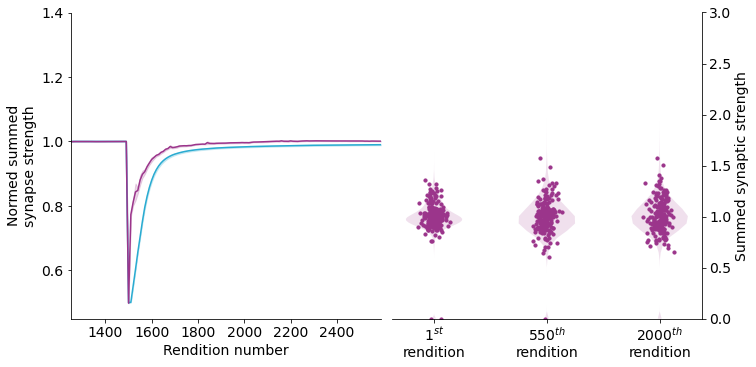

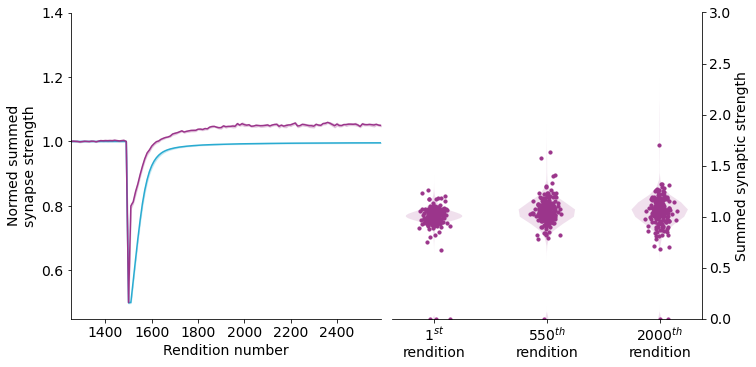

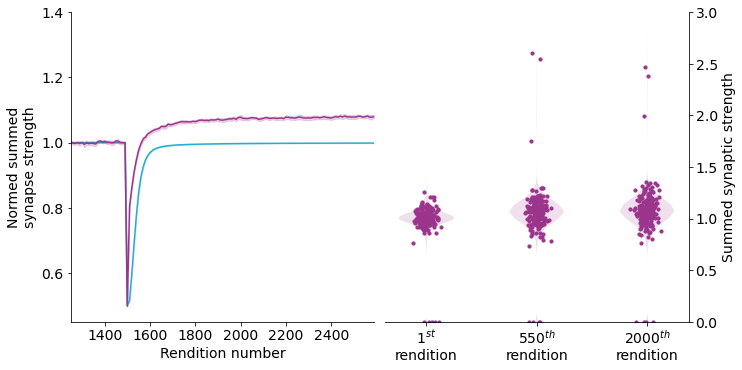

In [114]:
scale = 1.3
colors = get_equally_spaced_colors(3, cmap='winter')

for k, dist_data_for_name in enumerate(all_weight_dist_info):
    fig, axs = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(8 * scale, 4 * scale))

    if len(dist_data_for_name) > 0:
        mean_initial_summed_incoming_weight = np.mean(dist_data_for_name['all_summed_incoming_weights'][0])

#         widths = np.array([np.max(d) for d in dist_data_for_name['mean_weight_dists']])
        axs[1].set_ylabel('Summed synaptic strength')
        axs[1].yaxis.set_label_position('right')
        axs[1].yaxis.tick_right()
#         axs[1].tick_params(right=True, labelright=True, left=False, labelleft=False)
        parts = axs[1].violinplot(dist_data_for_name['all_summed_incoming_weights'] / mean_initial_summed_incoming_weight, showmeans=False, showextrema=False)
        for pc in parts['bodies']:
            pc.set_facecolor(unperturbed_purple)
#             pc.set_edgecolor('black')
            pc.set_alpha(0.15)
    
        num_to_sample = 200
        for i, dist_data in enumerate(dist_data_for_name['all_summed_incoming_weights']):
            indices_to_show = np.arange(len(dist_data))
            np.random.shuffle(indices_to_show)
            indices_to_show = indices_to_show[:num_to_sample]
            axs[1].scatter(i + 1 + np.random.normal(size=num_to_sample, scale=0.05), dist_data[indices_to_show] / mean_initial_summed_incoming_weight, s=10, color=unperturbed_purple, marker='o')
        axs[1].set_xticks([1, 2, 3])
        axs[1].set_xticklabels([
            r'$1^{st}$' + '\nrendition',
            r'$550^{th}$' + '\nrendition',
            r'$2000^{th}$'  + '\nrendition'
        ])
        set_font_size(axs[1], 14)
        
        axs[0].spines['top'].set_visible(False)
        axs[0].spines['right'].set_visible(False)
        axs[1].spines['top'].set_visible(False)
        axs[1].spines['left'].set_visible(False)
        
        axs[1].set_ylim(0, 3)
        axs[0].set_ylim(0.45, 1.4)
        
        timepoints = np.arange(125, 260, 1)

        make_figure_2_plot([
            dist_data_for_name['name'],
        ], labels=[
            '',
        ], condition_colors=[(unperturbed_purple, interneuron_blue)], timepoints=timepoints, offsets=149 * np.ones(3), vertical_spacing=0.,
        file_name_ext='all_3_silent', axs=[axs[0], axs[0]], fig=fig, tick_right=False, legend=False, ylabel2='Normed summed\nsynapse strength')
      
                
        set_font_size(axs[0], 14)
        save_fig(fig, './figures/paper/weight_trajectories_wide', f'{k}.svg')
        
#         axs[1].tick_params(right=False, labelright=False)
        
#         axs[k, 0].set_ylim(0, 0.0015)
#         bins = dist_data_for_name['summed_weight_bins']
#         for i_t, means in enumerate(dist_data_for_name['mean_weight_dists']):
#             stds = dist_data_for_name['std_weight_dists'][i_t]
            
#             axs[k, 1].fill_between(bins, means - stds, means + stds, color=colors[i_t], alpha=0.2)
#             axs[k, 1].plot(bins, means, color=colors[i_t])
        
fig.tight_layout()

['settle', 'GAMMA_0_']
settle__DROP_SEV_0.5_BETA_0.01_SEED_2106_GAMMA_0_ALPHA_1_0.05_ff_0.5_eir_6.0_ier_0.9_2022-02-13--16:27--40:5312
settle__DROP_SEV_0.5_BETA_0.01_SEED_2099_GAMMA_0_ALPHA_1_0.05_ff_0.5_eir_6.0_ier_0.9_2022-02-13--16:27--25:1887
settle__DROP_SEV_0.5_BETA_0.01_SEED_2131_GAMMA_0_ALPHA_1_0.05_ff_0.5_eir_6.0_ier_0.9_2022-02-13--16:37--32:8754
settle__DROP_SEV_0.5_BETA_0.01_SEED_2121_GAMMA_0_ALPHA_1_0.05_ff_0.5_eir_6.0_ier_0.9_2022-02-13--16:28--27:2544
settle__DROP_SEV_0.5_BETA_0.01_SEED_2117_GAMMA_0_ALPHA_1_0.05_ff_0.5_eir_6.0_ier_0.9_2022-02-13--16:28--23:2368
settle__DROP_SEV_0.5_BETA_0.01_SEED_2103_GAMMA_0_ALPHA_1_0.05_ff_0.5_eir_6.0_ier_0.9_2022-02-13--16:27--27:6747
['settle', 'GAMMA_0_']
settle__DROP_SEV_0.5_BETA_0.01_SEED_2106_GAMMA_0_ALPHA_1_0.05_ff_0.5_eir_6.0_ier_0.9_2022-02-13--16:27--40:5312
settle__DROP_SEV_0.5_BETA_0.01_SEED_2099_GAMMA_0_ALPHA_1_0.05_ff_0.5_eir_6.0_ier_0.9_2022-02-13--16:27--25:1887
settle__DROP_SEV_0.5_BETA_0.01_SEED_2131_GAMMA_0_ALPHA_1_0

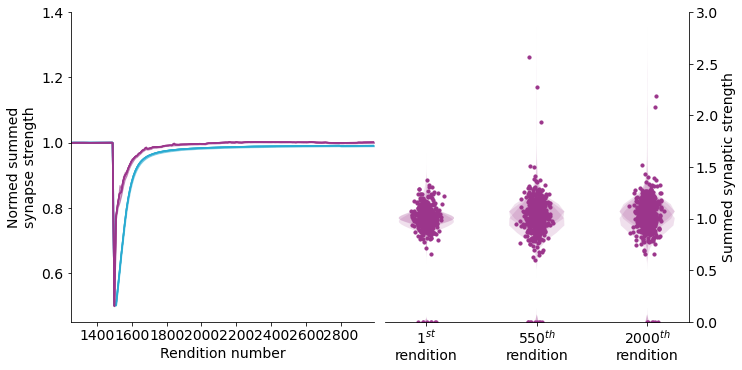

In [115]:
scale = 1.3
fig, axs = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(8 * scale, 4 * scale))

colors = get_equally_spaced_colors(3, cmap='winter')

for k, dist_data_for_name in enumerate(all_weight_dist_info):
    if len(dist_data_for_name) > 0:
        mean_initial_summed_incoming_weight = np.mean(dist_data_for_name['all_summed_incoming_weights'][0])

#         widths = np.array([np.max(d) for d in dist_data_for_name['mean_weight_dists']])
        axs[1].set_ylabel('Summed synaptic strength')
        axs[1].yaxis.set_label_position('right')
        axs[1].yaxis.tick_right()
#         axs[1].tick_params(right=True, labelright=True, left=False, labelleft=False)
        parts = axs[1].violinplot(dist_data_for_name['all_summed_incoming_weights'] / mean_initial_summed_incoming_weight, showmeans=False, showextrema=False)
        for pc in parts['bodies']:
            pc.set_facecolor(unperturbed_purple)
#             pc.set_edgecolor('black')
            pc.set_alpha(0.15)
    
        num_to_sample = 200
        for i, dist_data in enumerate(dist_data_for_name['all_summed_incoming_weights']):
            indices_to_show = np.arange(len(dist_data))
            np.random.shuffle(indices_to_show)
            indices_to_show = indices_to_show[:num_to_sample]
            axs[1].scatter(i + 1 + np.random.normal(size=num_to_sample, scale=0.05), dist_data[indices_to_show] / mean_initial_summed_incoming_weight, s=10, color=unperturbed_purple, marker='o')
        axs[1].set_xticks([1, 2, 3])
        axs[1].set_xticklabels([
            r'$1^{st}$' + '\nrendition',
            r'$550^{th}$' + '\nrendition',
            r'$2000^{th}$'  + '\nrendition'
        ])
        set_font_size(axs[1], 14)
        
        axs[0].spines['top'].set_visible(False)
        axs[0].spines['right'].set_visible(False)
        axs[1].spines['top'].set_visible(False)
        axs[1].spines['left'].set_visible(False)
        
        axs[1].set_ylim(0, 3)
        axs[0].set_ylim(0.45, 1.4)
        
        timepoints = np.arange(125, 300, 1)

        make_figure_2_plot([
            run_name_1,
        ], labels=[
            '',
        ], condition_colors=[(unperturbed_purple, interneuron_blue)], timepoints=timepoints, offsets=149 * np.ones(3), vertical_spacing=0.,
        file_name_ext='all_3_silent', axs=[axs[0], axs[0]], fig=fig, tick_right=False, legend=False, ylabel2='Normed summed\nsynapse strength')
      
                
        set_font_size(axs[0], 14)
        save_fig(fig, './figures/paper/weight_trajectories_wide', f'{k}.svg')
        
#         axs[1].tick_params(right=False, labelright=False)
        
#         axs[k, 0].set_ylim(0, 0.0015)
#         bins = dist_data_for_name['summed_weight_bins']
#         for i_t, means in enumerate(dist_data_for_name['mean_weight_dists']):
#             stds = dist_data_for_name['std_weight_dists'][i_t]
            
#             axs[k, 1].fill_between(bins, means - stds, means + stds, color=colors[i_t], alpha=0.2)
#             axs[k, 1].plot(bins, means, color=colors[i_t])
        
fig.tight_layout()

In [75]:
def make_interpolated_violin_plot_and_weight_traj(all_weight_dist_info, name, dist_timepoints):
    scale = 1.3
    fig, axs = plt.subplots(1, 1, sharex=False, sharey=False, figsize=(6 * scale, 4 * scale))

    dist_timepoints = np.array(dist_timepoints)
    colors = get_equally_spaced_colors(3, cmap='winter')

    for k, dist_data_for_name in enumerate(all_weight_dist_info):
        if len(dist_data_for_name) > 0:
            mean_initial_summed_incoming_weight = np.mean(dist_data_for_name['all_summed_incoming_weights'][0])
            widths = 250
            parts = axs.violinplot(dist_data_for_name['all_summed_incoming_weights'] / mean_initial_summed_incoming_weight, positions=dist_timepoints * 10, showmeans=False, showextrema=False, widths=widths)
            for pc in parts['bodies']:
                pc.set_facecolor(unperturbed_blue)
    #             pc.set_edgecolor('black')
                pc.set_alpha(0.15)
        
#             axs.set_ylim(0, 2)
            axs.set_xlim((dist_timepoints[0] - 20) * 10, (dist_timepoints[-1] + 20) * 10)

            num_to_sample = 200
            for i, dist_data in enumerate(dist_data_for_name['all_summed_incoming_weights']):
                indices_to_show = np.arange(len(dist_data))
                np.random.shuffle(indices_to_show)
                indices_to_show = indices_to_show[:num_to_sample]
                axs.scatter(dist_timepoints[i] * 10 + 1 + np.random.normal(size=num_to_sample, scale=25), dist_data[indices_to_show] / mean_initial_summed_incoming_weight,
                            s=10, color=unperturbed_blue, zorder=3)
            axs.set_xticks(dist_timepoints * 10)
            axs.set_xticklabels([
                r'$1^{st}$' + '\nrendition',
                r'$500^{th}$' + '\nrendition',
                r'$1500^{th}$'  + '\nrendition'
            ])
            axs.set_ylabel('Excitatory summed synaptic strength')
            axs.spines['top'].set_visible(False)
            axs.spines['right'].set_visible(False)
            axs.set_ylim(0, 4)

            timepoints_start = dist_timepoints[0] - 10 if dist_timepoints[0] - 10 > 0 else 0
            timepoints = np.arange(timepoints_start, dist_timepoints[-1] + 10)

            make_figure_2_plot([
                name,
            ], labels=[
                '',
            ], condition_colors=[(unperturbed_blue, interneuron_red)], timepoints=timepoints, offsets=dist_timepoints[0] * np.ones(3), vertical_spacing=0.,
            file_name_ext='all_3_silent', axs=[axs, axs], fig=fig, tick_right=False, legend=False, ylabel2='Mean normed\nsummed synapse\nstrength')
            set_font_size(axs, 14)
            
            save_fig(fig, './figures/paper/weight_trajectories', f'{k}.svg')
            

['pop_cont_drop3__SYN_PROP_DIST_0.6_DROP_SEV_0.5_']
pop_cont_drop3__SYN_PROP_DIST_0.6_DROP_SEV_0.5_LOADED_RUN_NAME_2022-01-03--18:03--45:0266_BETA_0.01_SEED_2000_ALPHA_2_0.005_ALPHA_1_0.06_GAMMA_0.01_ff_1.1_eir_2.5_ier_1.0_2022-01-03--23:59--48:5704
pop_cont_drop3__SYN_PROP_DIST_0.6_DROP_SEV_0.5_LOADED_RUN_NAME_2022-01-03--18:03--45:8208_BETA_0.01_SEED_2000_ALPHA_2_0.005_ALPHA_1_0.06_GAMMA_0.01_ff_1.1_eir_2.5_ier_1.0_2022-01-03--23:59--47:5704
pop_cont_drop3__SYN_PROP_DIST_0.6_DROP_SEV_0.5_LOADED_RUN_NAME_2022-01-03--18:03--45:0323_BETA_0.01_SEED_2000_ALPHA_2_0.005_ALPHA_1_0.06_GAMMA_0.01_ff_1.1_eir_2.5_ier_1.0_2022-01-03--23:59--47:5704
pop_cont_drop3__SYN_PROP_DIST_0.6_DROP_SEV_0.5_LOADED_RUN_NAME_2022-01-03--18:03--45:7994_BETA_0.01_SEED_2000_ALPHA_2_0.005_ALPHA_1_0.06_GAMMA_0.01_ff_1.1_eir_2.5_ier_1.0_2022-01-03--23:59--47:5704
pop_cont_drop3__SYN_PROP_DIST_0.6_DROP_SEV_0.5_LOADED_RUN_NAME_2022-01-03--18:03--45:1912_BETA_0.01_SEED_2000_ALPHA_2_0.005_ALPHA_1_0.06_GAMMA_0.01_ff_1.1_e

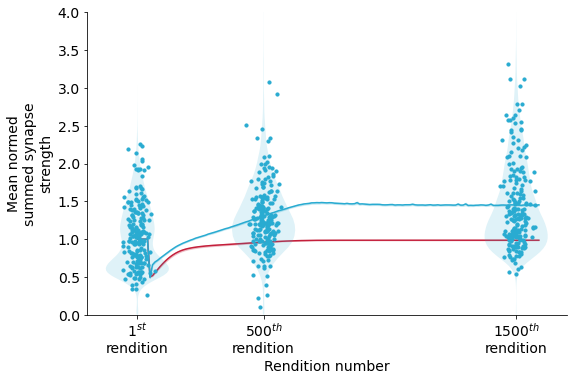

In [95]:
make_interpolated_violin_plot_and_weight_traj(all_weight_dist_info, pop_cont_drop_point_5_name_frags, [0, 50, 150])

In [ ]:
def make_figure_3(names, ylim=(0, 8), trials=[3], timepoints = [0, 10, 12, 299], spaced_colors=['#ff1717', '#d117ff', '#171bff']):    
    all_dirs = []
    for name in names:
        if type(name) is list:
            all_dirs.append([dirs for dirs in filter_list_by_name_frags(all_in_dir('./robustness'), name)])
        else:
            all_dirs.append([dirs for dirs in filter_list_by_name_frags(all_in_dir('./robustness'), [name])])
        
    labels = [
        'unperturbed',
        '130th rendition',
        '500th rendition',
    ]
    
    for i_t in trials:
        scale = 1.1
        d
       
        def create_split_freq_plot(row_start, row_end, col_start, fig, gs):
            sub_axs = [
                fig.add_subplot(gs[row_start:row_end, col_start]),
                fig.add_subplot(gs[row_start:row_end, (col_start+1):(col_start+6)])
            ]
            sub_axs[1].yaxis.tick_right()
            sub_axs[0].tick_params(bottom=False, labelbottom=False)
            sub_axs[0].set_ylabel('Number neurons')
            sub_axs[0].set_xlim(-1.5, 1.5)
            sub_axs[1].set_xlim(0.5, 45)
            sub_axs[0].set_ylim(0, 1000)
            sub_axs[1].set_ylim(0, 1000)
            sub_axs[0].set_xlabel('Silent')
            sub_axs[0].spines['right'].set_visible(False)
            sub_axs[0].spines['top'].set_visible(False)
            sub_axs[1].spines['left'].set_visible(False)
            sub_axs[1].spines['top'].set_visible(False)
            return sub_axs
            

        col_1_axs = [create_split_freq_plot(i, i+3, 6, fig, gs) for i in range(0, 6, 3)]
        col_2_axs = [create_split_freq_plot(i, i+3, 12, fig, gs) for i in range(0, 6, 3)]
        
        axs = [
            [create_split_freq_plot(0, 6, 0, fig, gs)],
            col_1_axs,
            col_2_axs,
        ]
        
        spk_bins_zero = None
        freqs_zero = None
        spk_bins_i_zero = None
        freqs_i_zero = None
        
        for idx, exp_dir_names in enumerate(all_dirs):
            j = 0
            exp_dir_names = sorted(exp_dir_names, key=lambda x: x[-4:])
            for i, data_load in load_exp_data(os.path.join('./robustness', exp_dir_names[i_t]), name_frags=['dropout_0']):
                if j < len(timepoints) and i == timepoints[j]:
                    data = data_load()
 
                    if j >= 1:
                        if idx == 0:
                            axs[j][idx][0].bar(spk_bins_zero[:1], freqs_zero[:1], color='gray', alpha=0.2, zorder=-j, width=1, label=labels[0])
                            axs[j][idx][1].plot(spk_bins_zero[1:], freqs_zero[1:], color='gray', alpha=1., zorder=-j, lw=2.5, label=labels[0])
                            
                            axs[j][idx][1].plot(spk_bins_i_zero, freqs_i_zero, '--', color='gray', alpha=1., zorder=-j, lw=2.5, label=labels[0] + ' inh')
                        else:
                            axs[j][idx][0].bar(spk_bins_zero[:1], freqs_zero[:1], color='gray', alpha=0.2, zorder=-j, width=1)
                            axs[j][idx][1].plot(spk_bins_zero[1:], freqs_zero[1:], color='gray', alpha=1., zorder=-j, lw=2.5)
                            
                            axs[j][idx][1].plot(spk_bins_i_zero, freqs_i_zero, '--', color='gray', alpha=1., zorder=-j, lw=2.5)

                    spk_bins = data['spk_bins']
                    freqs = data['freqs']
                    spks_for_i_cells = data['inh_raster']
                    if len(spks_for_i_cells) > 0:
                        spks_for_i_cells = spks_for_i_cells[1]
                        cell_labels, spks_i = bin_occurrences(spks_for_i_cells, min_val=4000, max_val=5000, bin_size=1)
                        spk_bins_i, freqs_i = bin_occurrences(spks_i, max_val=100, bin_size=1)
                    else:
                        spk_bins_i, freqs_i = (np.zeros(100), np.zeros(100))
                    
                    if j == 0:
                        spk_bins_zero = spk_bins
                        freqs_zero = freqs
                        spk_bins_i_zero = spk_bins_i
                        freqs_i_zero = freqs_i

                    if j >= 1 or (j == 0 and idx == 0):
                        color = 'black' if j < 1 else spaced_colors[idx]
                        if idx == 0:
                            axs[j][idx][0].bar(spk_bins[:1], freqs[:1], color=color, alpha=0.7, zorder=-j, width=1, label=labels[j])
                            axs[j][idx][1].plot(spk_bins[1:], freqs[1:], color=color, alpha=1., zorder=-j, lw=2.5, label=labels[j])
                            
                            axs[j][idx][1].plot(spk_bins_i, freqs_i, '--', color=color, alpha=1., zorder=-j, lw=2.5, label=labels[j] + ' inh')
                        else:
                            axs[j][idx][0].bar(spk_bins[:1], freqs[:1], color=color, alpha=0.7, zorder=-j, width=1)
                            axs[j][idx][1].plot(spk_bins[1:], freqs[1:], color=color, alpha=1., zorder=-j, lw=2.5)
                            
                            axs[j][idx][1].plot(spk_bins_i, freqs_i, '--', color=color, alpha=1., zorder=-j, lw=2.5)
            
                        if idx == (len(all_dirs) - 1):
                            axs[j][idx][1].set_xlabel('Spikes per neuron')
                        
                        if idx == 0:
                            axs[j][idx][1].legend(frameon=False)
                    
                        set_font_size(axs[j][idx][0], 18)
                        set_font_size(axs[j][idx][1], 18)

                    j += 1
                    
        axs[0][0][0].set_ylim(0, 1000)
        axs[0][0][1].set_xlabel('Spikes per neuron')
        plt.locator_params(axis='x', nbins=5)
        save_fig(fig, './figures/paper/fig_3', f'trial_{i_t}.png')

## Figure 3: comparisons of the firing rate distributions of HVC(RA) cells for three cases: (1) single-cell rule + pop-level rule + STDP, (2) single-cell rule + STDP, (3) pop-level rule + STDP

### First run only

In [116]:
def make_figure_3b(name, ylim=(0, 8), initial_timepoint_range=(0, 4), final_timepoint_range=(170, 180), color='blue'):    
    all_dirs = [dirs for dirs in filter_list_by_name_frags(all_in_dir('./robustness'), name)]
            
    labels = [
        'unperturbed',
        '900th rendition',
    ]
    
    scale = 1.9
    fig = plt.figure(constrained_layout=True, figsize=(5 * scale, 5 * scale))
    gs = gridspec.GridSpec(ncols=4, nrows=2, figure=fig)
    
    def create_split_freq_plot(row_start, row_end, col_start, fig, gs):
        sub_axs = [
            fig.add_subplot(gs[row_start:row_end, col_start]),
            fig.add_subplot(gs[row_start:row_end, (col_start+1):(col_start+3)])
        ]
        sub_axs[1].yaxis.tick_right()
        sub_axs[0].tick_params(bottom=False, labelbottom=False)
        sub_axs[0].set_xlim(-1.5, 1.5)
        sub_axs[1].set_xlim(0.5, 45)
        sub_axs[0].set_ylim(0, 1000)
        sub_axs[1].set_ylim(0, 1000)
        sub_axs[0].set_xlabel('Silent')
        sub_axs[0].spines['right'].set_visible(False)
        sub_axs[0].spines['top'].set_visible(False)
        sub_axs[1].spines['left'].set_visible(False)
        sub_axs[1].spines['top'].set_visible(False)
        return sub_axs
    
    axs = [
        create_split_freq_plot(0, 1, 0, fig, gs),
        create_split_freq_plot(1, 2, 0, fig, gs),
    ]
    
    
    firing_rate_stats_initial = {
        'spk_bins_e': None,
        'freqs_e': [],
        'spk_bins_i': None,
        'freqs_i': [],
    }
    firing_rate_stats_final = copy(firing_rate_stats_initial)
           
    for idx, exp_dir_name in enumerate(all_dirs):
        for i, data_load in load_exp_data(os.path.join('./robustness', exp_dir_name)):
            if (i >= initial_timepoint_range[0] and i <= initial_timepoint_range[1]) or (i >= final_timepoint_range[0] and i <= final_timepoint_range[1]):
                    data = data_load()

                    spk_bins_e = data['spk_bins']
                    freqs_e = data['freqs']
                    spks_for_i_cells = data['inh_raster']
                    
                    if len(spks_for_i_cells) > 0:
                        spks_for_i_cells = spks_for_i_cells[1]
                        cell_labels, spks_i = bin_occurrences(spks_for_i_cells, min_val=1600, max_val=1850, bin_size=1)
                        spk_bins_i, freqs_i = bin_occurrences(spks_i, max_val=100, bin_size=1)
                    else:
                        spk_bins_i, freqs_i = (np.zeros(100), np.zeros(100))
                        
                    if (i >= initial_timepoint_range[0] and i <= initial_timepoint_range[1]):
                        firing_rate_stats = firing_rate_stats_initial
                    else:
                        firing_rate_stats = firing_rate_stats_final
                        
                    if firing_rate_stats['spk_bins_e'] is None:
                        firing_rate_stats['spk_bins_e'] = spk_bins_e
                    if firing_rate_stats['spk_bins_i'] is None:
                        firing_rate_stats['spk_bins_i'] = spk_bins_i
                    firing_rate_stats['freqs_e'].append(freqs_e)
                    firing_rate_stats['freqs_i'].append(freqs_i)
        
    for firing_rate_stats in [firing_rate_stats_initial, firing_rate_stats_final]:
        firing_rate_stats['freqs_e_zero'] = (np.mean(np.stack(firing_rate_stats['freqs_e']), axis=0)[0], np.std(np.stack(firing_rate_stats['freqs_e']), axis=0)[0])
        firing_rate_stats['freqs_i_zero'] = (np.mean(np.stack(firing_rate_stats['freqs_i']), axis=0)[0], np.std(np.stack(firing_rate_stats['freqs_i']), axis=0)[0])
        firing_rate_stats['freqs_e'] = (np.mean(np.stack(firing_rate_stats['freqs_e']), axis=0)[1:], np.std(np.stack(firing_rate_stats['freqs_e']), axis=0)[1:])
        firing_rate_stats['freqs_i'] = (np.mean(np.stack(firing_rate_stats['freqs_i']), axis=0)[1:], np.std(np.stack(firing_rate_stats['freqs_i']), axis=0)[1:])

    freqs_e_initial_low = firing_rate_stats_initial['freqs_e'][0] - firing_rate_stats_initial['freqs_e'][1]
    freqs_e_initial_high = firing_rate_stats_initial['freqs_e'][0] + firing_rate_stats_initial['freqs_e'][1]
    axs[0][1].fill_between(firing_rate_stats_initial['spk_bins_e'][1:], y1=freqs_e_initial_low, y2=freqs_e_initial_high, color='black', alpha=0.4, zorder=-1)
    axs[0][1].plot(firing_rate_stats_initial['spk_bins_e'][1:], firing_rate_stats_initial['freqs_e'][0], color='black', alpha=1., zorder=-1, lw=1.2, label=labels[0])
#     axs[0][1].errorbar(firing_rate_stats_initial['spk_bins_e'][1:], firing_rate_stats_initial['freqs_e'][0], yerr=firing_rate_stats_initial['freqs_e'][1], color='black', alpha=1., zorder=-1)
#     axs[0][1].scatter(firing_rate_stats_initial['spk_bins_e'][1:], firing_rate_stats_initial['freqs_e'][0], color='black', alpha=1., zorder=-1, s=20, label=labels[0]) 
    
    freqs_i_initial_low = firing_rate_stats_initial['freqs_i'][0] - firing_rate_stats_initial['freqs_i'][1]
    freqs_i_initial_high = firing_rate_stats_initial['freqs_i'][0] + firing_rate_stats_initial['freqs_i'][1]
    axs[1][1].fill_between(firing_rate_stats_initial['spk_bins_i'][1:], y1=freqs_i_initial_low, y2=freqs_i_initial_high, color=interneuron_blue, alpha=0.2, zorder=-1)
    axs[1][1].plot(firing_rate_stats_initial['spk_bins_i'][1:], firing_rate_stats_initial['freqs_i'][0], color=interneuron_blue, alpha=0.6, zorder=-1, lw=1.2, label=labels[0] + ' inh')

    freqs_e_final_low = firing_rate_stats_final['freqs_e'][0] - firing_rate_stats_final['freqs_e'][1]
    freqs_e_final_high = firing_rate_stats_final['freqs_e'][0] + firing_rate_stats_final['freqs_e'][1]
    axs[0][1].fill_between(firing_rate_stats_final['spk_bins_e'][1:], y1=freqs_e_final_low, y2=freqs_e_final_high, color=unperturbed_purple, alpha=0.4, zorder=-1)
    axs[0][1].plot(firing_rate_stats_final['spk_bins_e'][1:], firing_rate_stats_final['freqs_e'][0], color=unperturbed_purple, alpha=1., zorder=0, lw=1.2, label=labels[1])
#     axs[0][1].errorbar(firing_rate_stats_final['spk_bins_e'][1:], firing_rate_stats_final['freqs_e'][0], yerr=firing_rate_stats_final['freqs_e'][1], color=unperturbed_purple, alpha=1., zorder=-1)
#     axs[0][1].scatter(firing_rate_stats_final['spk_bins_e'][1:], firing_rate_stats_final['freqs_e'][0], color=unperturbed_purple, alpha=1., zorder=-1, s=20, label=labels[0]) 
    
    freqs_i_final_low = firing_rate_stats_final['freqs_i'][0] - firing_rate_stats_final['freqs_i'][1]
    freqs_i_final_high = firing_rate_stats_final['freqs_i'][0] + firing_rate_stats_final['freqs_i'][1]
    axs[1][1].fill_between(firing_rate_stats_final['spk_bins_i'][1:], y1=freqs_i_final_low, y2=freqs_i_final_high, color=interneuron_blue, alpha=0.4, zorder=-1)
    axs[1][1].plot(firing_rate_stats_final['spk_bins_i'][1:], firing_rate_stats_final['freqs_i'][0], color=interneuron_blue, alpha=1., zorder=0, lw=1.2, label=labels[1] + ' inh')

    axs[0][0].errorbar(-.5, firing_rate_stats_initial['freqs_e_zero'][0], yerr=firing_rate_stats_initial['freqs_e_zero'][1], color='black', alpha=1., zorder=-1)
    axs[0][0].bar(-.5, firing_rate_stats_initial['freqs_e_zero'][0], color='black', alpha=0.7, zorder=-1, width=0.75)
    axs[0][0].errorbar(.5, firing_rate_stats_final['freqs_e_zero'][0], yerr=firing_rate_stats_final['freqs_e_zero'][1], color=unperturbed_purple, alpha=1., zorder=-1)
    axs[0][0].bar(.5, firing_rate_stats_final['freqs_e_zero'][0], color=unperturbed_purple, alpha=0.7, zorder=-1, width=0.75)    

    axs[1][0].errorbar(-.5, firing_rate_stats_initial['freqs_i_zero'][0], yerr=firing_rate_stats_initial['freqs_i_zero'][1], color=interneuron_blue, alpha=1., zorder=-1)
    axs[1][0].bar(-.5, firing_rate_stats_initial['freqs_i_zero'][0], color=interneuron_blue, alpha=0.4, zorder=-1, width=0.75)
    axs[1][0].errorbar(.5, firing_rate_stats_final['freqs_i_zero'][0], yerr=firing_rate_stats_final['freqs_i_zero'][1], color=interneuron_blue, alpha=1., zorder=-1)
    axs[1][0].bar(.5, firing_rate_stats_final['freqs_i_zero'][0], color=interneuron_blue, alpha=0.7, zorder=-1, width=0.75)
    
    axs[0][0].set_ylabel('Excitatory counts')
    axs[1][0].set_ylabel('Inhibitory counts')
    axs[0][1].set_xlim(0.8, 8)
    axs[1][1].set_xlim(0.8, 90)
#     axs[0].spines['top'].set_visible(False)
#     axs[1].spines['top'].set_visible(False)
    axs[0][1].set_ylim(0, 1200)
    axs[1][1].set_ylim(0, 18)
#     axs[1].set_ylim(0, 16)

#     axs[0].legend(frameon=False)
    
    for i in range(2):
        set_font_size(axs[0][i], 15)
        set_font_size(axs[1][i], 15)

    plt.locator_params(axis='x', nbins=5)
    
    save_fig(fig, './figures/paper/firing_rates', f'{" ".join(name)}.svg')

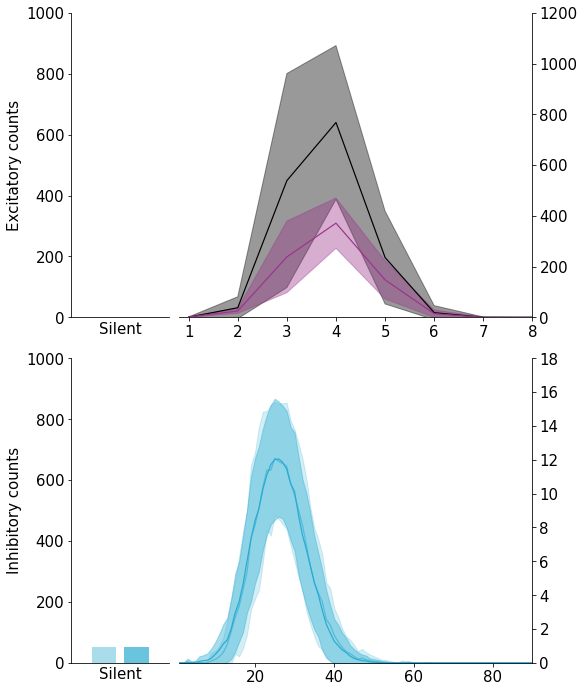

In [117]:
make_figure_3b(run_name_1, initial_timepoint_range=(144, 149), final_timepoint_range=(280, 300))

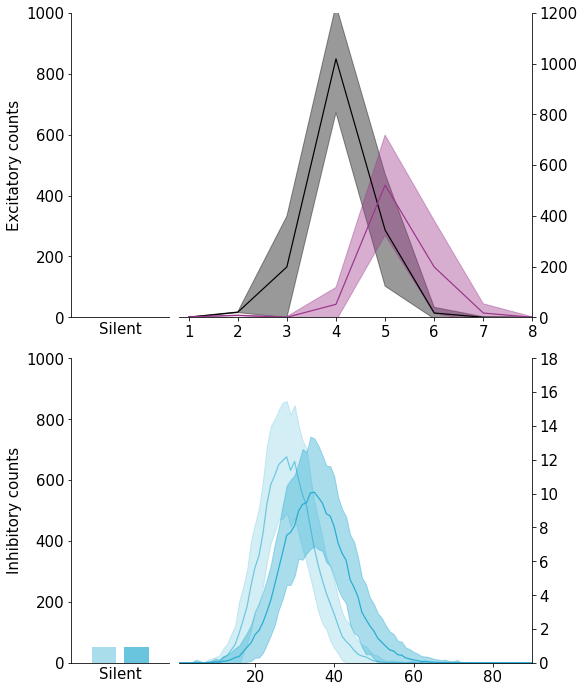

In [119]:
make_figure_3b(run_name_2, initial_timepoint_range=(144, 149), final_timepoint_range=(280, 300))

In [162]:
def make_figure_4_averaged(names, labels, spaced_colors, dropout=0, file_name_ext='', ylim=(0, 8), cap=100, layer_size=25):
    scale = 1.4
    fig, axs = plt.subplots(3, 2, sharex=False, sharey=False, figsize=(10 * scale, 7.5 * scale))
    plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
    
    all_dirs = []
    for name in names:
        if type(name) is list:
            all_dirs.append([dirs for dirs in filter_list_by_name_frags(all_in_dir('./robustness'), name)])
        else:
            all_dirs.append([dirs for dirs in filter_list_by_name_frags(all_in_dir('./robustness'), [name])])

    x = np.concatenate([np.ones(layer_size) * (i/layer_size) for i in range(0, 4000, layer_size)])
    
    for idx, exp_dir_names in enumerate(all_dirs):
        to_plot = ['pop_firing_rates', 'inh_pop_firing_rates', 'relative_prop_speeds', 'r_squareds']
        
        plot_data = {}
        for var in to_plot:
            plot_data[var] = {'raw': []}
        
        for j, exp_dir_name in enumerate(exp_dir_names):
            if exp_dir_name not in recovered_exp_names:
                continue
            for var in to_plot:
                plot_data[var]['raw'].append([])

            for i, load_data in load_exp_data(os.path.join('./robustness', exp_dir_name), name_frags=[f'dropout_{dropout}']):
                if i == cap:
                    break
                data = load_data()

                pop_firing_rate = np.sum(data['exc_cells_initially_active'])
                if data['exc_cells_newly_active'] is not None:
                    pop_firing_rate += np.sum(data['exc_cells_newly_active'])
                plot_data['pop_firing_rates']['raw'][-1].append(pop_firing_rate)
                
                inh_pop_firing_rate = np.sum(data['inh_raster'])
                plot_data['inh_pop_firing_rates']['raw'][-1].append(inh_pop_firing_rate)

                first_spk_times = data['first_spk_times']
                filtered_indices = data['surviving_cell_indices'] & (~np.isnan(first_spk_times))

                x_firing = x[filtered_indices]
                first_spk_times_nonnan = first_spk_times[filtered_indices]

                res = stats.linregress(first_spk_times_nonnan, x_firing)
                plot_data['relative_prop_speeds']['raw'][-1].append(res.slope)
                plot_data['r_squareds']['raw'][-1].append(np.square(res.rvalue))
                
        for var in to_plot:
            plot_data[var]['means'] = safe_apply_stat(plot_data[var]['raw'], np.mean)
            plot_data[var]['stds'] = safe_apply_stat(plot_data[var]['raw'], np.std)
            plot_data[var]['sems'] = safe_apply_stat(plot_data[var]['raw'], lambda x: np.std(x) / np.sqrt(len(x)))
            
        epochs = np.arange(0, cap * 10, 10)
        
        axs[0, idx].fill_between(
            epochs,
            plot_data['pop_firing_rates']['means'] - plot_data['pop_firing_rates']['sems'],
            plot_data['pop_firing_rates']['means'] + plot_data['pop_firing_rates']['sems'],
            color=spaced_colors[idx], alpha=0.15
        )
        axs[0, idx].plot(epochs, plot_data['pop_firing_rates']['means'], c=spaced_colors[idx], lw=1., label=labels[idx])
        axs[0, idx].fill_between(
            epochs,
            plot_data['inh_pop_firing_rates']['means'] - plot_data['inh_pop_firing_rates']['sems'],
            plot_data['inh_pop_firing_rates']['means'] + plot_data['inh_pop_firing_rates']['sems'],
            color=spaced_colors[idx], alpha=0.15
        )
        line, = axs[0, idx].plot(epochs, plot_data['inh_pop_firing_rates']['means'], '-', c=spaced_colors[idx], lw=1., label=f'{labels[idx]} inh', )
        line.set_dashes([4, 4])
        axs[1, idx].fill_between(
            epochs,
            plot_data['relative_prop_speeds']['means'] - plot_data['relative_prop_speeds']['sems'],
            plot_data['relative_prop_speeds']['means'] + plot_data['relative_prop_speeds']['sems'],
            color=spaced_colors[idx], alpha=0.15
        )
        axs[1, idx].plot(epochs, plot_data['relative_prop_speeds']['means'], c=spaced_colors[idx], lw=1.)
        axs[2, idx].fill_between(
            epochs,
            plot_data['r_squareds']['means'] - plot_data['r_squareds']['sems'],
            plot_data['r_squareds']['means'] + plot_data['r_squareds']['sems'],
            color=spaced_colors[idx], alpha=0.15
        )
        axs[2, idx].plot(epochs, plot_data['r_squareds']['means'],c=spaced_colors[idx], lw=1.)
        axs[0, idx].set_ylim(0, 10e7)
        axs[1, idx].set_ylim(300, 700)
        axs[2, idx].set_ylim(0.6, 1.05)
        
    axs[0, 0].set_ylabel('Population spikes\nper activation')
    axs[1, 0].set_ylabel('Propagation speed (layers/s)')
    axs[2, 0].set_ylabel(r'$R^2$')
    
    axs[0, 1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        
    for i in range(3):
        for j in range(2):
            axs[i, j].set_xlim(0, cap * 10)
            axs[i, 0].set_xlabel('Rendition number\n\n')
            set_font_size(axs[i, j], 16)
    plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.22, wspace=0.35)
    save_fig(fig, './figures/paper/fig_4', f'population_activity_+_prop_speed_{file_name_ext}.png')

## Figure 4: metrics of dynamics

### 50% dropout of HVC(RA) projectors

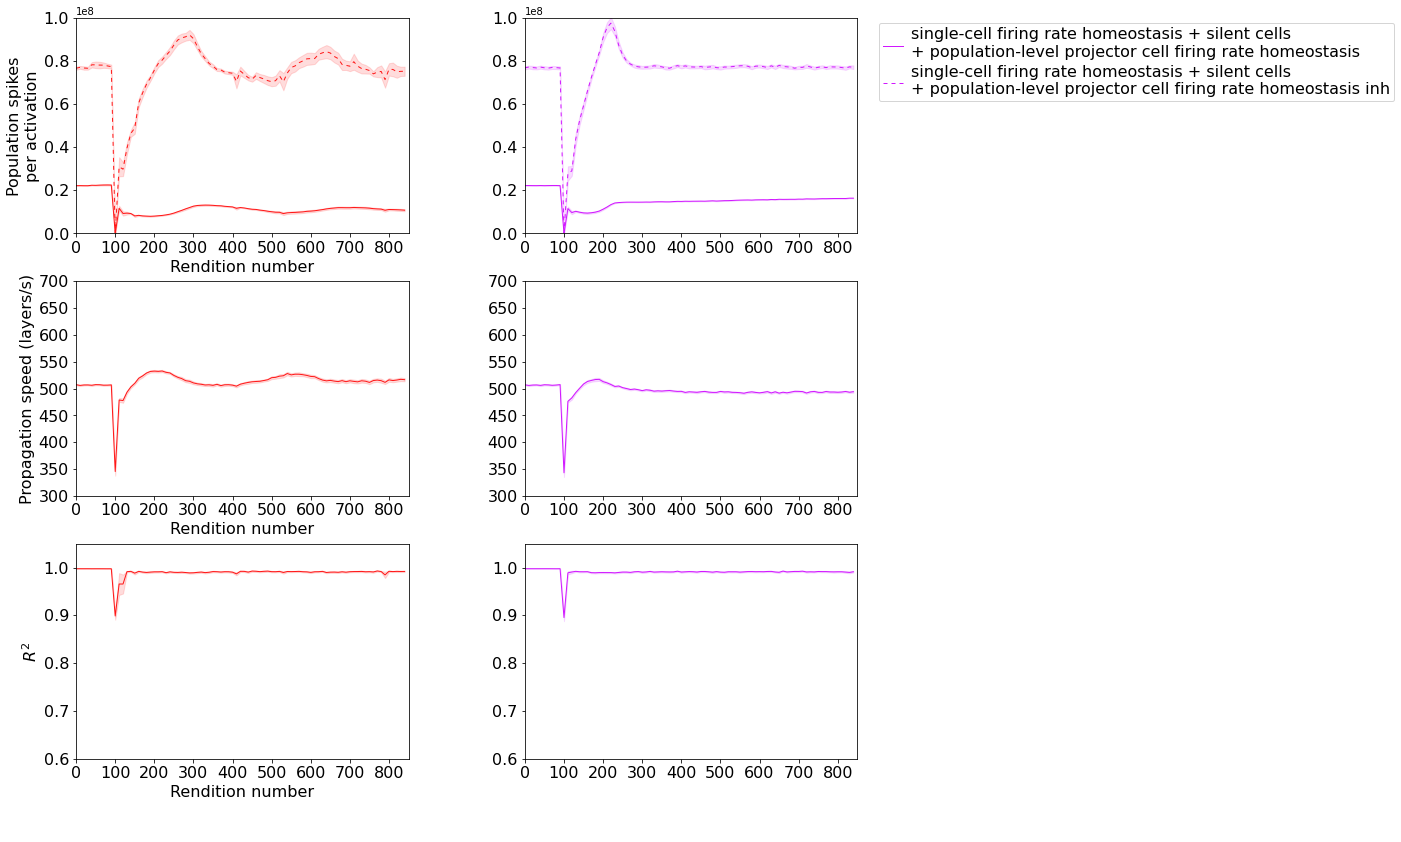

In [163]:
make_figure_4_averaged([
    biological_silent_name_frags,
    biological_silent_pop_name_frags,
], [
    'single-cell firing rate homeostasis + silent cells',
    'single-cell firing rate homeostasis + silent cells\n+ population-level projector cell firing rate homeostasis',
], colors_for_trials[3:], file_name_ext='both_rules', cap=75, layer_size=50)